In [1]:
import json
import multiprocessing
import operator
import os
import pickle
from itertools import product
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import numpy as np
import pandas as pd
import pyarrow.feather as feather
import scipy
import seaborn as sns
import shap
import xgboost as xgb
from scipy.stats import gaussian_kde
from adjustText import adjust_text
from sklearn.cluster import KMeans
from sklearn.datasets import load_svmlight_file
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import partial_dependence
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, silhouette_score
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from kneed import KneeLocator
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.kde import gaussian_kde
import scipy.stats
from scipy.stats import fisher_exact
from sklearn.model_selection import KFold

Please import `gaussian_kde` from the `scipy.stats` namespace; the `scipy.stats.kde` namespace is deprecated and will be removed in SciPy 2.0.0.


In [2]:
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'Arial'
gene_select_dir = "/dcs05/hongkai/data/next_cutntag/bulk/dna_methylation/cpg_island"
gene_select_filename = "gene_categories.json"
gene_select_dir_filename = os.path.join(gene_select_dir, gene_select_filename)
with open(gene_select_dir_filename) as fp:
    gene_select_dict = json.load(fp)
gene_select_dict["coding_all"] = gene_select_dict["coding_cpg"] + gene_select_dict["coding_non_cpg"]

In [3]:
target_pair_mapping_file_36x = "/dcs05/hongkai/data/next_cutntag/script/utils/target_pair_short_hand.csv"
target_pair_mapping_df = pd.read_csv(target_pair_mapping_file_36x, sep=" ")
target_pairs_selected_file = "/dcs05/hongkai/data/next_cutntag/bulk/explainability/pdp_explain_results/target_pairs_selected.json"
# target_pairs_selected_file = args.target_pairs_selected_file
with open(target_pairs_selected_file) as fp:
    target_pairs = json.load(fp)

In [4]:
# helper functions
def map_target_names(target_pair_list, target_pair_mapping_df, from_col="targets", to_col="shorthand" ):
    cur_names = target_pair_mapping_df.loc[:,from_col].to_list()
    new_names = target_pair_mapping_df.loc[:,to_col].to_list()
    print()
    result = target_pair_list
    for i in range(len(cur_names)):
        cur_name = cur_names[i]
        new_name = new_names[i]
        result = [target_pair.replace(cur_name, new_name) for target_pair in result]
    return(result)
def column_to_rownames(wgc, var="pos"):
    pos_list_full = wgc[var]
    wgc = wgc.set_index(var)
    return wgc
def remove_model_in_param_grid(best_params):
    results = {}
    for param in best_params.keys():
        new_param = param.replace("model__", "")
        results[new_param] = best_params[param]
    return results
def calculate_effect_size(x, y, method="slope"):
    # print(method)
    if method == "slope":
        result = (y[-1]-y[0])/(x[-1]-x[0])
    elif method == "auc":
        sorted_indices = np.argsort(x)
        x_sorted = x[sorted_indices]
        y_sorted = y[sorted_indices]

        # Calculate area under the curve
        result = np.trapz(y_sorted, x_sorted)
    elif method == "end":
        result = y[-1]
    return result

def get_average_lines(pdp_results, target_pair):
    all_arrays = []
    for random_seed in pdp_results.keys():
        individual_lines = pdp_results[random_seed]["coding_all"][target_pair]["individual"]
        all_arrays.append(individual_lines[0])
    stacked = np.vstack(all_arrays)
    return stacked

In [5]:
data = {}
model_designs = ["rnaseq_vs_hiplex"]
frag_types = ["mixed"]
cluster_result = pd.read_csv("/dcs05/hongkai/data/next_cutntag/bulk/explainability/leave_one_out/V/all/coding_cpg_clusters=5.csv", index_col=0)
cluster_result = cluster_result.set_index("gene_id")

In [6]:
gene_select_list = gene_select_dict["coding_all"]

In [7]:
rnaseq_dir = "/dcs05/hongkai/data/next_cutntag/bulk/RNA-seq"
dge_filename = "diff_expr_all_update.csv"
dge_dir_filename = f"{rnaseq_dir}/{dge_filename}"
dge_raw = pd.read_csv(dge_dir_filename, index_col=0)
# dge = dge_raw.dropna(axis = 0, how = 'any') # might be wrong
dge = dge_raw
dge.loc[:, "log2FoldChange"] = dge.loc[:, "log2_T"] - dge.loc[:, "log2_V"]

In [8]:
# load data
data = {}
model_designs = ["rnaseq_vs_hiplex_rm_outlier_log"]
model_design = "rnaseq_vs_hiplex_rm_outlier_log"
frag_types = ["mixed"]
frag_type = "mixed"
gene_select_names = ["coding_all"]
gene_select_name = "coding_all"

# read in rnaseq TPM
rnaseq_dir = "/dcs05/hongkai/data/next_cutntag/bulk/RNA-seq"
rnaseq_filename = "RNA_seq_TPM_all.csv"
rnaseq_dir_filename = os.path.join(rnaseq_dir, rnaseq_filename)
rnaseq = pd.read_csv(rnaseq_dir_filename, sep=",", header=0, index_col=0)
# RNAseq is log transformed
rnaseq.loc[:, "sqrt_V"] = np.log10(rnaseq.loc[:, "V1V2"]+1)

# read in hiplex norm counts
wgc_root_dir = "/dcs05/hongkai/data/next_cutntag/bulk/wgc"
frag_type = "mixed"
bin_size = "promoter_-1000-1000"
scen = "V"
target_qc_type = "all"
post_process = "libnorm"
wgc_dir = os.path.join(wgc_root_dir, frag_type, bin_size)
wgc_filename = f"{scen}_{frag_type}_{bin_size}_colQC-{target_qc_type}_{post_process}.feather"
wgc_dir_filename = os.path.join(wgc_dir, wgc_filename)
wgc_raw = feather.read_feather(wgc_dir_filename)
with open('/dcs05/hongkai/data/next_cutntag/script/utils/filtered_target_pairs.json', 'r') as file:
    features = json.load(file)
wgc_vals = wgc_raw[features]
zero_hiplex_genes = wgc_raw["pos"][wgc_vals.sum(axis=1) == 0].to_list()
wgc_raw[features] = np.log10(wgc_raw[features]+1)
wgc_raw[features] = (wgc_raw[features] - wgc_raw[features].min()) / (wgc_raw[features].max() - wgc_raw[features].min())

features = ["pos"]+features
wgc_raw = wgc_raw.loc[:, features]

wgc_raw_list = wgc_raw.loc[:, "pos"].values.tolist()
overlap_gene_list = list(set(wgc_raw_list) & set(gene_select_list))
rnaseq_avail = rnaseq.loc[overlap_gene_list, ["gene_id", "sqrt_V"]]
# filter genes with extremely high gene expression
with open("/dcs05/hongkai/data/next_cutntag/bulk/explainability/rnaseq_hiplex_cutoff.json", 'r') as f:
    rnaseq_cutoffs = json.load(f)
q99 = rnaseq_cutoffs[model_design]
rnaseq_avail = rnaseq_avail.loc[rnaseq_avail.loc[:, "sqrt_V"] <= q99,:]
zero_rnaseq_genes = rnaseq_avail["gene_id"][rnaseq_avail["sqrt_V"]==0].to_list()
zero_all_genes = list(set(zero_hiplex_genes) & set(zero_rnaseq_genes))
rnaseq_wgc_raw = rnaseq_avail.merge(wgc_raw, left_on="gene_id", right_on="pos", how="inner")
rnaseq_wgc_raw = rnaseq_wgc_raw.set_index("gene_id")
rnaseq_wgc_raw = rnaseq_wgc_raw.loc[~rnaseq_wgc_raw.index.isin(zero_all_genes), :]
rnaseq_wgc = rnaseq_wgc_raw.drop(columns=["pos"], inplace=False)
rnaseq_wgc_train, rnaseq_wgc_test = train_test_split(rnaseq_wgc, test_size=0.2, random_state=42)
rnaseq_wgc_train_X = rnaseq_wgc_train.drop(columns=["sqrt_V"], inplace=False)
rnaseq_wgc_train_y = rnaseq_wgc_train.loc[:, "sqrt_V"].values
rnaseq_wgc_test_X = rnaseq_wgc_test.drop(columns=["sqrt_V"], inplace=False)
rnaseq_wgc_test_y = rnaseq_wgc_test.loc[:, "sqrt_V"].values
rnaseq_wgc_all_X = rnaseq_wgc.drop(columns=["sqrt_V"], inplace=False)
rnaseq_wgc_all_y = rnaseq_wgc.loc[:, "sqrt_V"].values


In [9]:
rnaseq_wgc_all_X.shape

(19718, 501)

In [10]:
# load treated data
rnaseq_dir = "/dcs05/hongkai/data/next_cutntag/bulk/RNA-seq"
rnaseq_filename = "RNA_seq_TPM_all.csv"
rnaseq_dir_filename = os.path.join(rnaseq_dir, rnaseq_filename)
rnaseq = pd.read_csv(rnaseq_dir_filename, sep=",", header=0, index_col=0)
# rnaseq.loc[:, "sqrt_V"] = rnaseq.loc[:, "sqrt_V1V2"]
# rnaseq.loc[:, "sqrt_V"] = rnaseq.loc[:, "sqrt_V"]**2
rnaseq.loc[:, "sqrt_T"] = np.log10(rnaseq.loc[:, "T1T2"]+1)

wgc_root_dir = "/dcs05/hongkai/data/next_cutntag/bulk/wgc"
frag_type = "mixed"
bin_size = "promoter_-1000-1000"
scen = "T"
target_qc_type = "all"
post_process = "libnorm"
wgc_dir = os.path.join(wgc_root_dir, frag_type, bin_size)
# /dcs05/hongkai/data/next_cutntag/bulk/wgc/mixed/promoter_-1000-1000/V_mixed_promoter_-1000-1000_colQC-all_libnorm.featherX
wgc_filename = f"{scen}_{frag_type}_{bin_size}_colQC-{target_qc_type}_{post_process}.feather"
wgc_dir_filename = os.path.join(wgc_dir, wgc_filename)
wgc_raw = feather.read_feather(wgc_dir_filename)
with open('/dcs05/hongkai/data/next_cutntag/script/utils/filtered_target_pairs.json', 'r') as file:
    features = json.load(file)
wgc_vals = wgc_raw[features]
zero_hiplex_genes = wgc_raw["pos"][wgc_vals.sum(axis=1) == 0].to_list()
wgc_raw[features] = np.log10(wgc_raw[features]+1)
wgc_raw[features] = (wgc_raw[features] - wgc_raw[features].min()) / (wgc_raw[features].max() - wgc_raw[features].min())

features = ["pos"]+features
wgc_raw = wgc_raw.loc[:, features]

wgc_raw_list = wgc_raw.loc[:, "pos"].values.tolist()
overlap_gene_list = list(set(wgc_raw_list) & set(gene_select_list))
rnaseq_avail = rnaseq.loc[overlap_gene_list, ["gene_id", "sqrt_T"]]
# filter outlier
q99 = rnaseq_cutoffs[model_design]
# rnaseq_avail = rnaseq_avail.loc[rnaseq_avail.loc[:, "sqrt_T"] <= q99,:]
zero_rnaseq_genes = rnaseq_avail["gene_id"][rnaseq_avail["sqrt_T"]==0].to_list()
zero_all_genes = list(set(zero_hiplex_genes) & set(zero_rnaseq_genes))
# rnaseq_avail = rnaseq_avail.loc[rnaseq_avail.loc[:, "sqrt_V"] > 0,:]
rnaseq_wgc_raw = rnaseq_avail.merge(wgc_raw, left_on="gene_id", right_on="pos", how="inner")
rnaseq_wgc_raw = rnaseq_wgc_raw.set_index("gene_id")
rnaseq_wgc_raw = rnaseq_wgc_raw.loc[rnaseq_wgc_all_X.index,:]
# print(rnaseq_wgc_raw.shape)
# rnaseq_wgc_raw = rnaseq_wgc_raw.loc[~rnaseq_wgc_raw.index.isin(zero_all_genes), :]
# print(rnaseq_wgc_raw.shape)
rnaseq_wgc = rnaseq_wgc_raw.drop(columns=["pos"], inplace=False)
rnaseq_wgc_all_X_T = rnaseq_wgc.drop(columns=["sqrt_T"], inplace=False)
rnaseq_wgc_all_y_T = rnaseq_wgc.loc[:, "sqrt_T"].values
print(rnaseq_wgc_all_X_T.shape)

(19718, 501)


In [11]:
rnaseq_wgc_all_X_T.index

Index(['ENSG00000169727', 'ENSG00000213889', 'ENSG00000176678',
       'ENSG00000008018', 'ENSG00000174521', 'ENSG00000169598',
       'ENSG00000196427', 'ENSG00000128313', 'ENSG00000100473',
       'ENSG00000255423',
       ...
       'ENSG00000120948', 'ENSG00000172789', 'ENSG00000171017',
       'ENSG00000174173', 'ENSG00000167740', 'ENSG00000204688',
       'ENSG00000122254', 'ENSG00000189376', 'ENSG00000171199',
       'ENSG00000196470'],
      dtype='object', name='gene_id', length=19718)

In [12]:
rnaseq_wgc_all_X.index

Index(['ENSG00000169727', 'ENSG00000213889', 'ENSG00000176678',
       'ENSG00000008018', 'ENSG00000174521', 'ENSG00000169598',
       'ENSG00000196427', 'ENSG00000128313', 'ENSG00000100473',
       'ENSG00000255423',
       ...
       'ENSG00000120948', 'ENSG00000172789', 'ENSG00000171017',
       'ENSG00000174173', 'ENSG00000167740', 'ENSG00000204688',
       'ENSG00000122254', 'ENSG00000189376', 'ENSG00000171199',
       'ENSG00000196470'],
      dtype='object', name='gene_id', length=19718)

Processing fold 1/5...
{'bootstrap': True, 'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}
rf
Train genes: 15774, Test genes: 3944
before filtering
pearson:	0.2764306374931634
spearman:	0.20797330707046782
after filtering
pearson:	0.44221841952110696
spearman:	0.41869293671148433


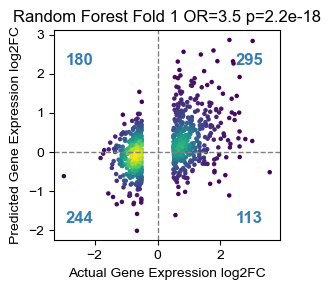

pearson:	0.3777848784141726
spearman:	0.3516901210118898


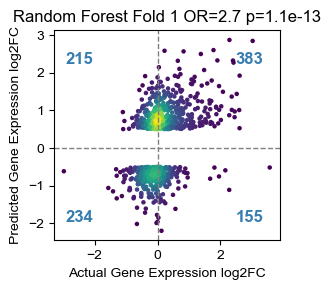

pearson:	0.5710596244218917
spearman:	0.5691646974500448


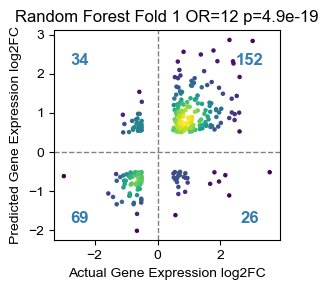

pearson:	0.2764306374931634
spearman:	0.20797330707046782


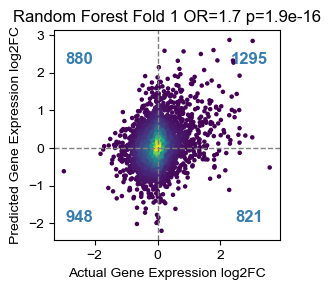

lr
Train genes: 15774, Test genes: 3944
before filtering
pearson:	0.17583360316211444
spearman:	0.14882312820899488
after filtering
pearson:	0.2987668682911371
spearman:	0.28438184270035755


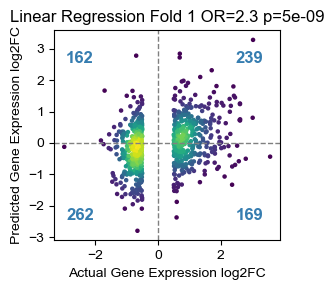

pearson:	0.24691231767044164
spearman:	0.23270916062053618


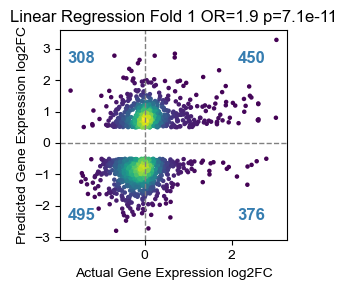

pearson:	0.4102713898898253
spearman:	0.4063365459482686


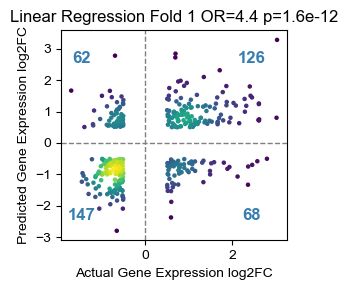

pearson:	0.17583360316211444
spearman:	0.14882312820899488


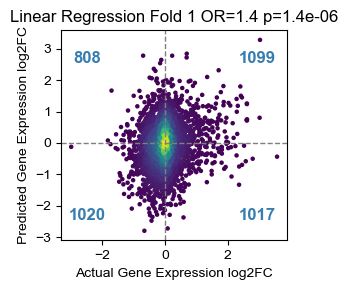

lr_ctrl
Train genes: 15774, Test genes: 3944
before filtering
pearson:	-2.0113782814589716e-05
spearman:	-0.001341057695075005
after filtering
pearson:	-0.005161560263567575
spearman:	-0.0014007757908839037


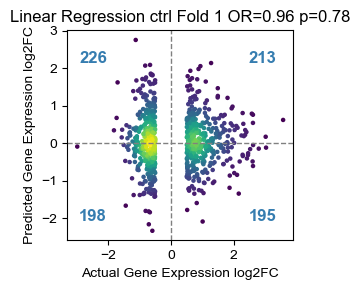

pearson:	0.004173854936285765
spearman:	-0.00715981226985569


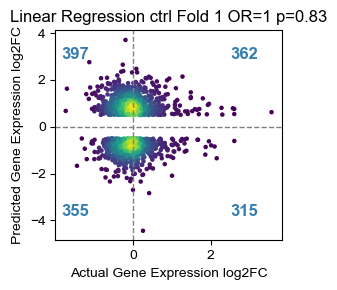

pearson:	-0.0001224443755226555
spearman:	-0.01250905423002713


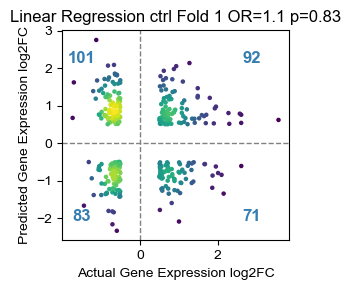

pearson:	-2.0113782814589716e-05
spearman:	-0.001341057695075005


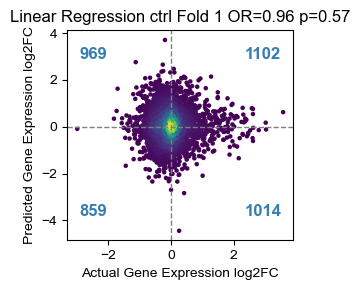

rf_ctrl
Train genes: 15774, Test genes: 3944
before filtering
pearson:	-0.0005184699832870573
spearman:	-0.0023782103999368566
after filtering
pearson:	0.012352126795692862
spearman:	0.021010490889519565


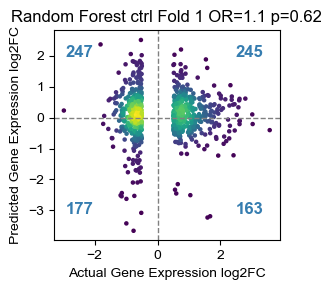

pearson:	0.010349233665517045
spearman:	0.009213483160648572


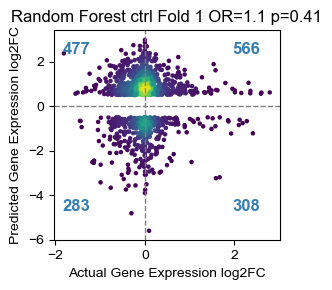

pearson:	0.03884535407890719
spearman:	0.04655985802905834


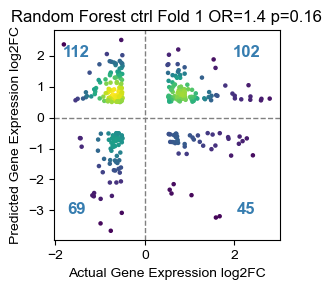

pearson:	-0.0005184699832870573
spearman:	-0.0023782103999368566


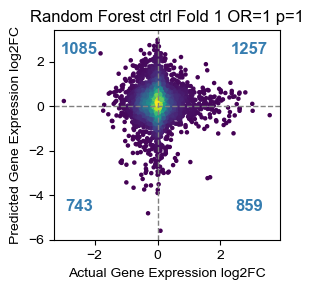

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


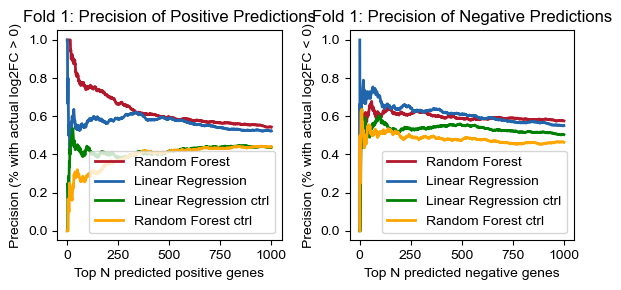

Processing fold 2/5...
{'bootstrap': True, 'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}
rf
Train genes: 15774, Test genes: 3944
before filtering
pearson:	0.2813237369758016
spearman:	0.2200415703049452
after filtering
pearson:	0.4624166572740014
spearman:	0.4267657514650871


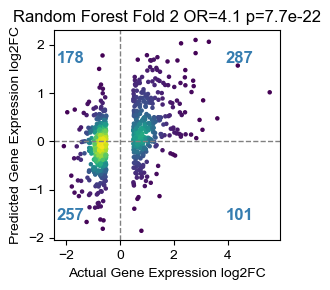

pearson:	0.3715794672850313
spearman:	0.36140706312052884


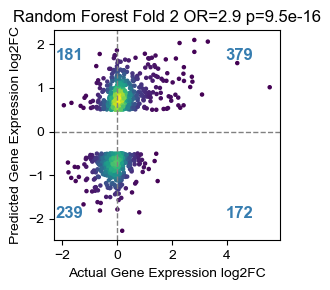

pearson:	0.5799361457419052
spearman:	0.5851266790773934


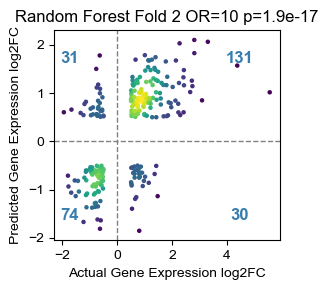

pearson:	0.2813237369758016
spearman:	0.2200415703049452


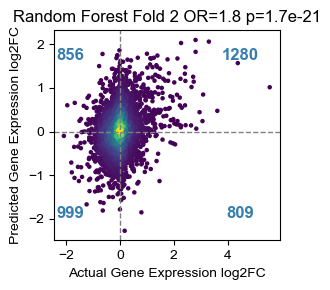

lr
Train genes: 15774, Test genes: 3944
before filtering
pearson:	0.23057615261263537
spearman:	0.20462463490036445
after filtering
pearson:	0.366856250378388
spearman:	0.34089171829729653


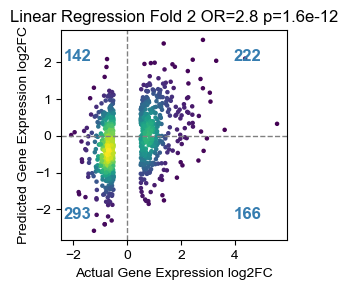

pearson:	0.31026046907478666
spearman:	0.27977301147645495


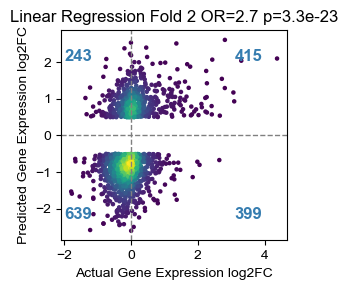

pearson:	0.48125627083464273
spearman:	0.4294223619007512


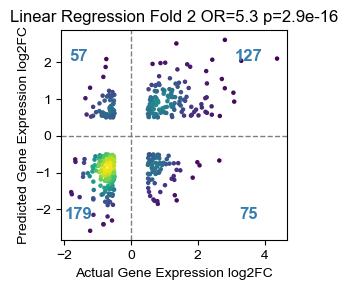

pearson:	0.23057615261263537
spearman:	0.20462463490036445


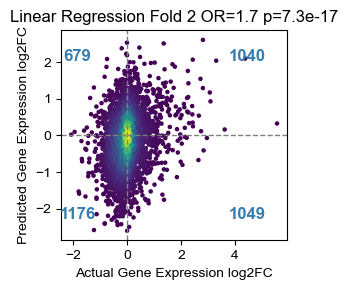

lr_ctrl
Train genes: 15774, Test genes: 3944
before filtering
pearson:	0.0014239602872256785
spearman:	0.00033985227892704094
after filtering
pearson:	0.00227955950097829
spearman:	0.007521611559651042


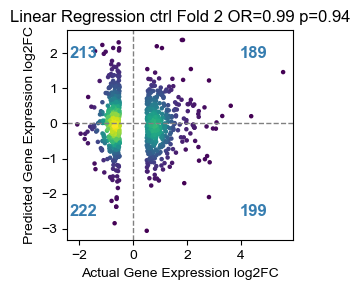

pearson:	-0.003443405574813559
spearman:	-0.030504788652133547


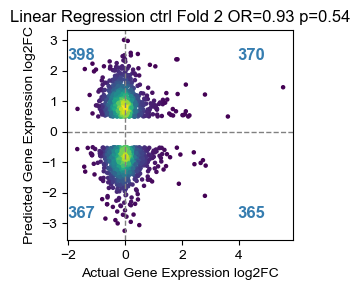

pearson:	-0.003724171163786415
spearman:	-0.02758751903896229


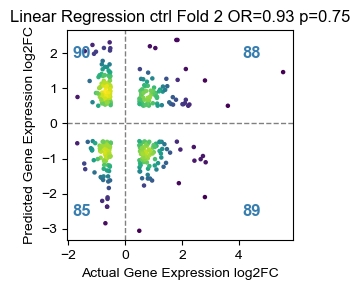

pearson:	0.0014239602872256785
spearman:	0.00033985227892704094


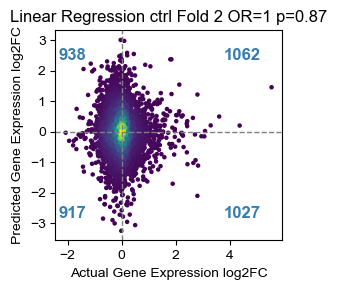

rf_ctrl
Train genes: 15774, Test genes: 3944
before filtering
pearson:	0.019901512256668186
spearman:	0.020093965178353018
after filtering
pearson:	0.05204438204610461
spearman:	0.044545223556439056


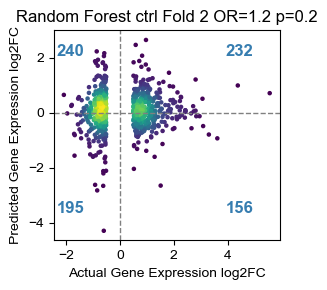

pearson:	0.033130199375246666
spearman:	0.029163697895073726


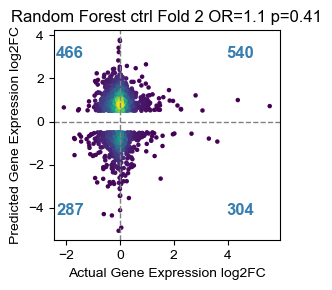

pearson:	0.09621872021016202
spearman:	0.12430585132270722


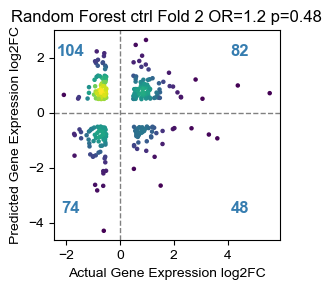

pearson:	0.019901512256668186
spearman:	0.020093965178353018


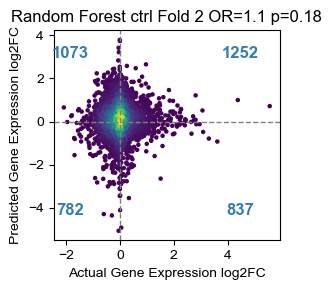

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


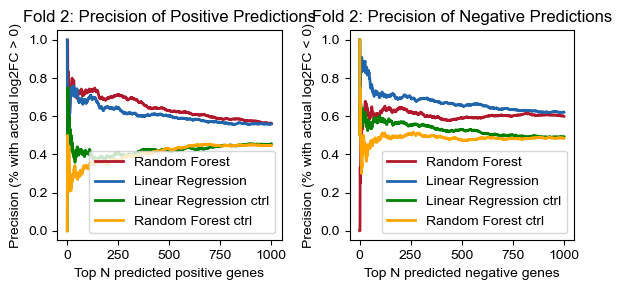

Processing fold 3/5...
{'bootstrap': True, 'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}
rf
Train genes: 15774, Test genes: 3944
before filtering
pearson:	0.26790779962087563
spearman:	0.21351764201811108
after filtering
pearson:	0.4424574107963729
spearman:	0.4050915134207458


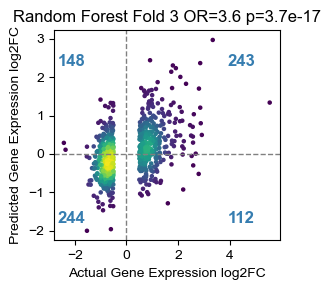

pearson:	0.37201041996543377
spearman:	0.333512940544262


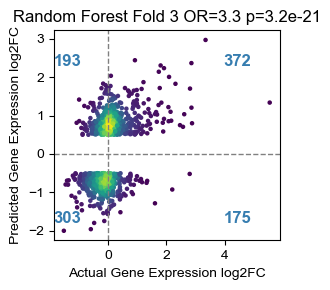

pearson:	0.5844641335190484
spearman:	0.5598945460537157


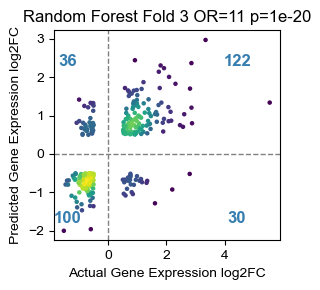

pearson:	0.26790779962087563
spearman:	0.21351764201811108


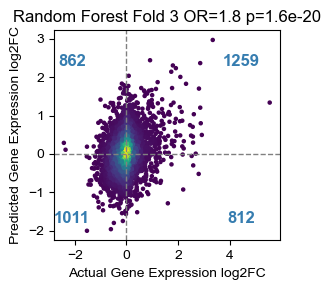

lr
Train genes: 15774, Test genes: 3944
before filtering
pearson:	0.18815803073576376
spearman:	0.16974037367588732
after filtering
pearson:	0.31650052975983245
spearman:	0.2931465507339101


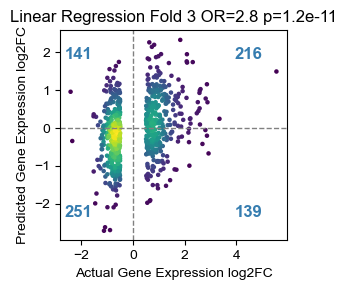

pearson:	0.2574731237725828
spearman:	0.2547602084864417


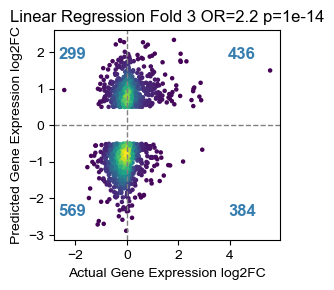

pearson:	0.4223859476571221
spearman:	0.39597077783298573


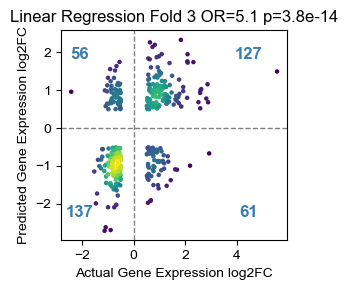

pearson:	0.18815803073576376
spearman:	0.16974037367588732


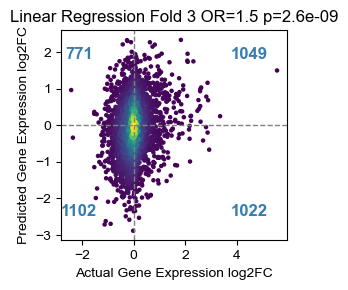

lr_ctrl
Train genes: 15774, Test genes: 3944
before filtering
pearson:	-0.0051267266414942595
spearman:	0.014925782295915088
after filtering
pearson:	-0.0388941899382467
spearman:	-0.0285766656250959


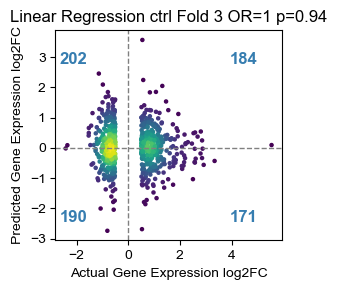

pearson:	-0.004212521829153108
spearman:	0.008158794780866915


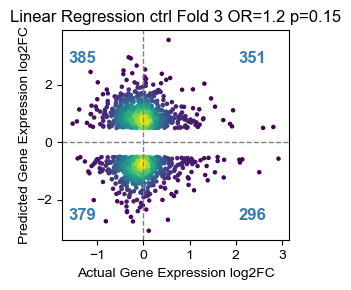

pearson:	-0.055445463780934595
spearman:	-0.05156798875902153


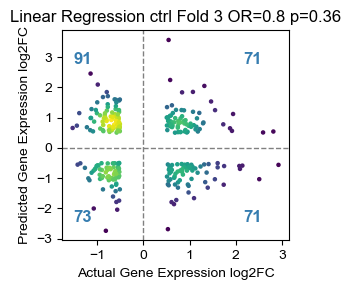

pearson:	-0.0051267266414942595
spearman:	0.014925782295915088


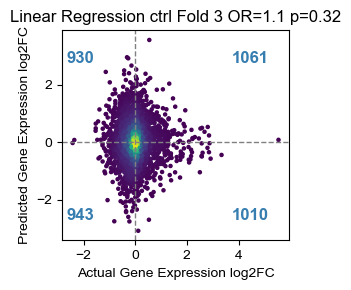

rf_ctrl
Train genes: 15774, Test genes: 3944
before filtering
pearson:	-0.007421748581877564
spearman:	-0.017529423051902897
after filtering
pearson:	-0.015819890713233083
spearman:	-0.01756635868069776


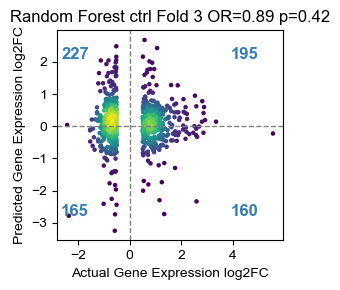

pearson:	0.003380416661538419
spearman:	0.0006139531394743886


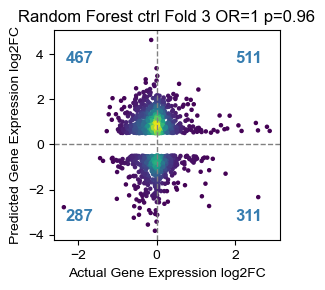

pearson:	0.008349083156163586
spearman:	0.00041083638671705956


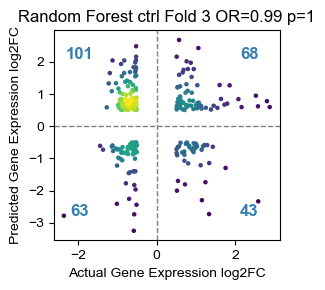

pearson:	-0.007421748581877564
spearman:	-0.017529423051902897


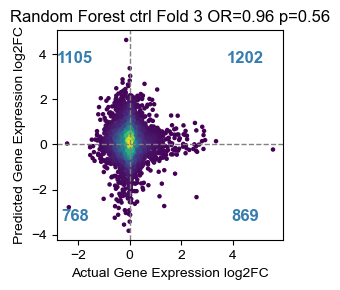

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


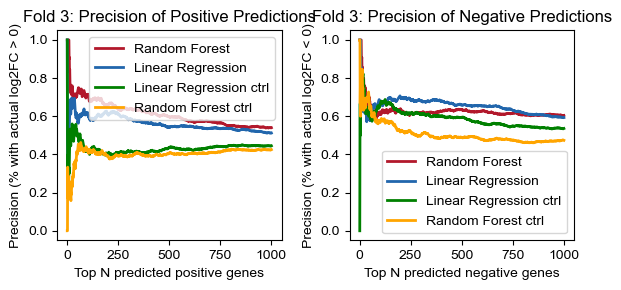

Processing fold 4/5...
{'bootstrap': True, 'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}
rf
Train genes: 15775, Test genes: 3943
before filtering
pearson:	0.25218814736058853
spearman:	0.21659842450545083
after filtering
pearson:	0.42815290670098155
spearman:	0.38233249134278613


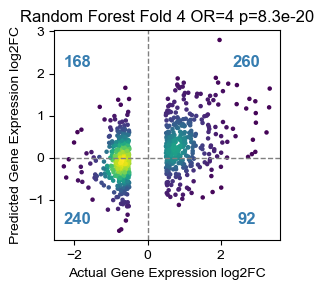

pearson:	0.32922443675163054
spearman:	0.31167009574822085


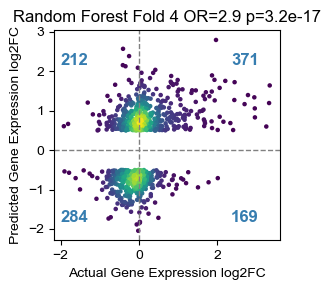

pearson:	0.5234438841297159
spearman:	0.4860928104261997


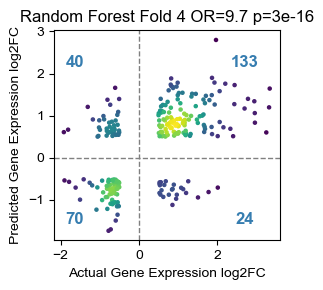

pearson:	0.25218814736058853
spearman:	0.21659842450545083


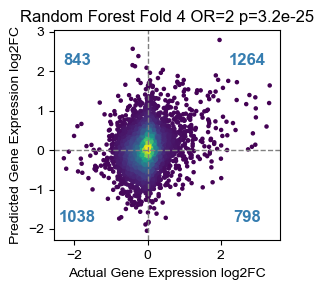

lr
Train genes: 15775, Test genes: 3943
before filtering
pearson:	0.19289034686951106
spearman:	0.1669852204394977
after filtering
pearson:	0.33612679413020696
spearman:	0.2993688320509979


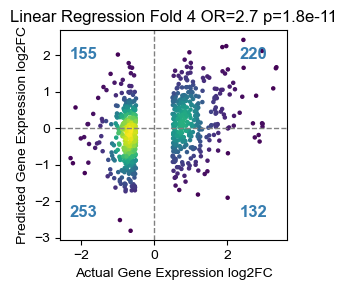

pearson:	0.26005250562083215
spearman:	0.2278602471527918


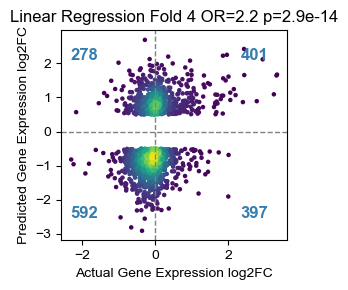

pearson:	0.4529036374265678
spearman:	0.4036079189896462


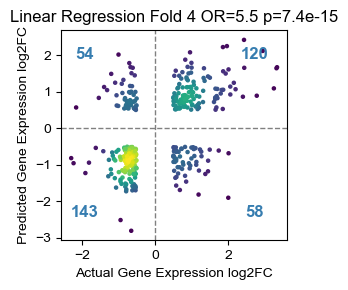

pearson:	0.19289034686951106
spearman:	0.1669852204394977


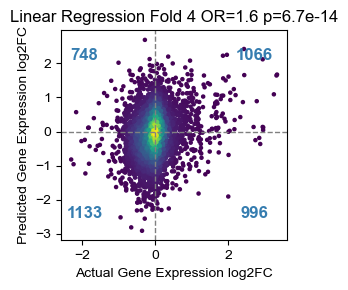

lr_ctrl
Train genes: 15775, Test genes: 3943
before filtering
pearson:	-0.013189094220634523
spearman:	-0.010200198978511791
after filtering
pearson:	0.002113741976744482
spearman:	-0.00829675957325128


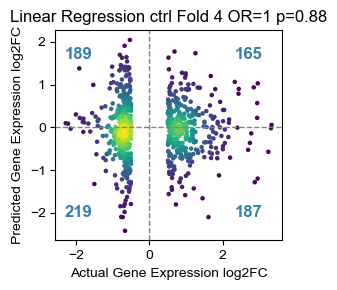

pearson:	-0.020522458841392234
spearman:	-0.01922016738577246


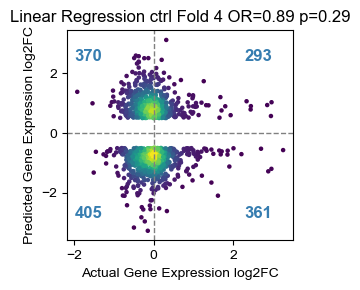

pearson:	0.006344348996488916
spearman:	-0.01415509083800755


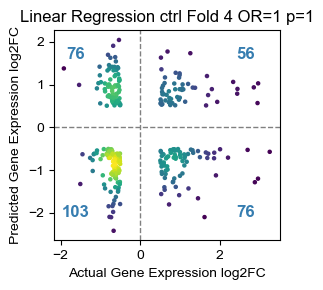

pearson:	-0.013189094220634523
spearman:	-0.010200198978511791


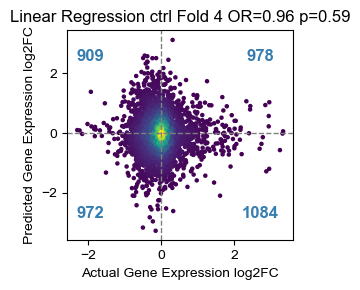

rf_ctrl
Train genes: 15775, Test genes: 3943
before filtering
pearson:	0.0017504969447376055
spearman:	-0.0055861793122063035
after filtering
pearson:	-0.01085752572477134
spearman:	-0.009126255110376532


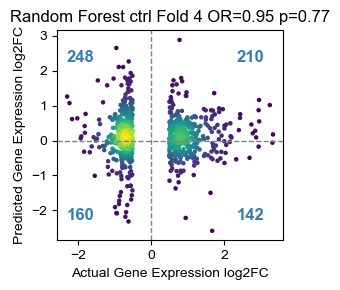

pearson:	0.01111463008583016
spearman:	0.004582030755223095


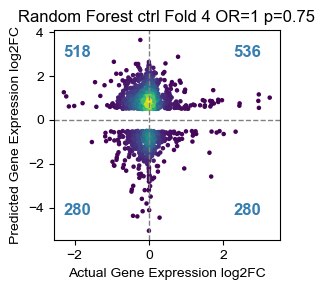

pearson:	0.0006291215917355948
spearman:	-0.011654852628709786


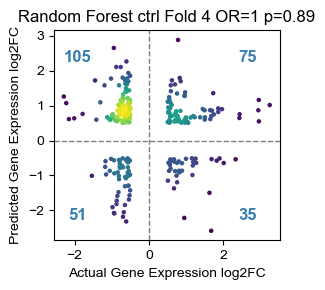

pearson:	0.0017504969447376055
spearman:	-0.0055861793122063035


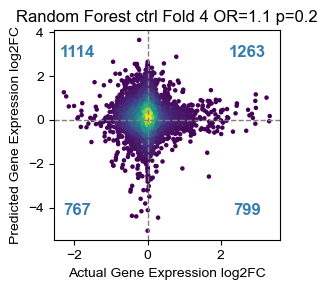

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


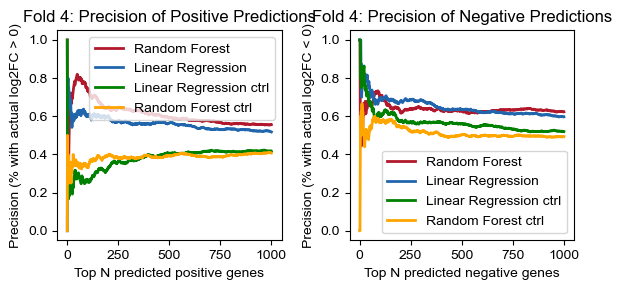

Processing fold 5/5...
{'bootstrap': True, 'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}
rf
Train genes: 15775, Test genes: 3943
before filtering
pearson:	0.2612129011797864
spearman:	0.21772394296381928
after filtering
pearson:	0.42077534636808356
spearman:	0.4030280131886275


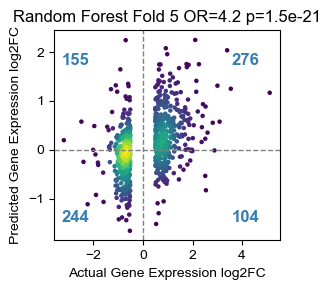

pearson:	0.3625435186573028
spearman:	0.35865471551262884


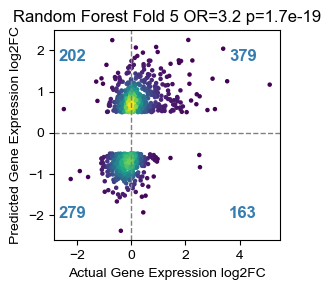

pearson:	0.5573884400550629
spearman:	0.5233445012942715


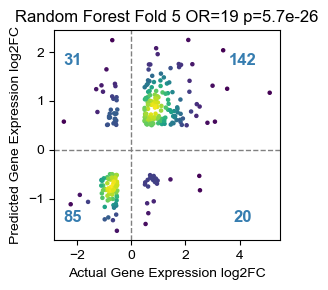

pearson:	0.2612129011797864
spearman:	0.21772394296381928


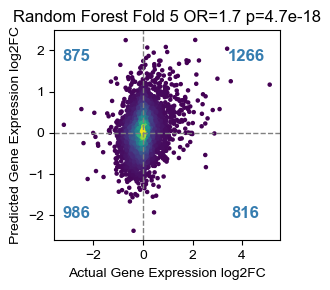

lr
Train genes: 15775, Test genes: 3943
before filtering
pearson:	0.22019603094279472
spearman:	0.20845340303002483
after filtering
pearson:	0.3654401585606585
spearman:	0.35829059974425304


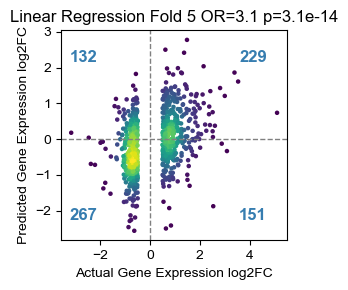

pearson:	0.29731519410088003
spearman:	0.2908835392621248


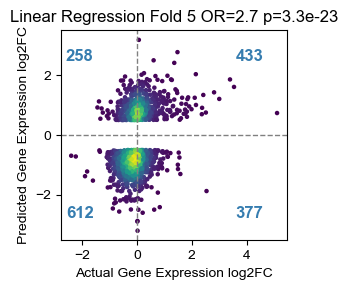

pearson:	0.4802687817159152
spearman:	0.4591447322072109


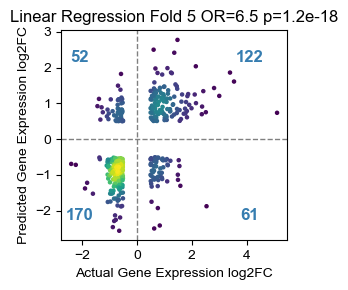

pearson:	0.22019603094279472
spearman:	0.20845340303002483


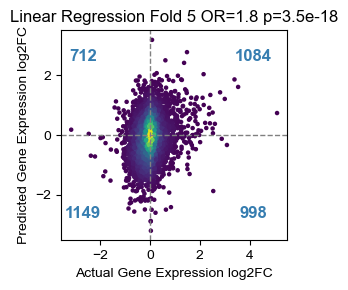

lr_ctrl
Train genes: 15775, Test genes: 3943
before filtering
pearson:	-0.02230270944204352
spearman:	-0.028257191412124953
after filtering
pearson:	-0.02779736718359223
spearman:	-0.03935689860552224


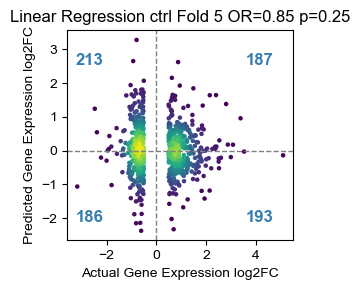

pearson:	-0.025650448422415366
spearman:	-0.048095377058616634


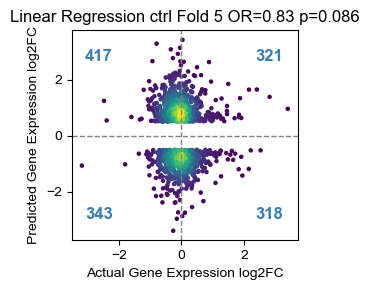

pearson:	-0.01620400873115174
spearman:	-0.025884408324347723


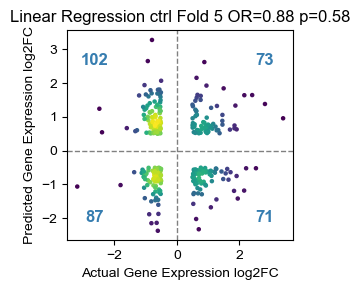

pearson:	-0.02230270944204352
spearman:	-0.028257191412124953


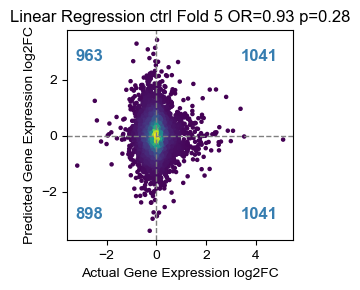

rf_ctrl
Train genes: 15775, Test genes: 3943
before filtering
pearson:	-0.016261190763900937
spearman:	-0.03375013675226312
after filtering
pearson:	-0.028862562509927386
spearman:	-0.04378279863978198


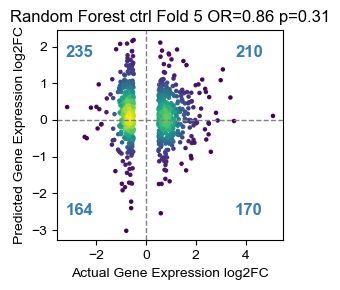

pearson:	-0.010746904381852425
spearman:	-0.03566296011716796


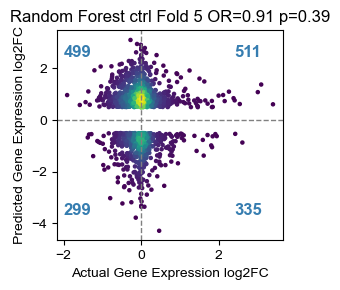

pearson:	-0.025148621985146384
spearman:	-0.04092813406380922


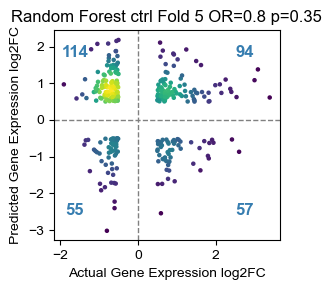

pearson:	-0.016261190763900937
spearman:	-0.03375013675226312


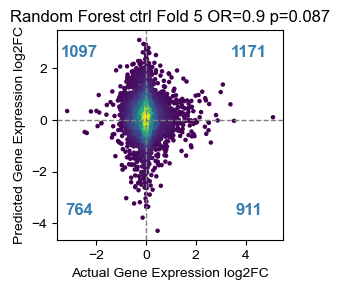

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


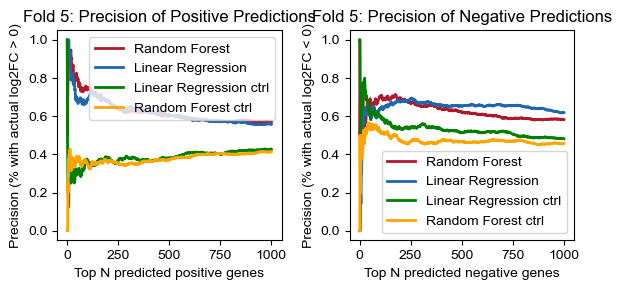

Cross-validation completed!
Results stored for 5 folds


In [13]:


model_design="rnaseq_vs_hiplex_rm_outlier_log"
gene_select_name ="coding_all"
frag_type="mixed"
models={}
model_params_file = f'/dcs05/hongkai/data/next_cutntag/script/explainability/{model_design}/{gene_select_name}.json'
results_dict = {}

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Get all indices for cross-validation
all_indices = np.arange(rnaseq_wgc_all_X.shape[0])

for fold_idx, (train_idx, test_idx) in enumerate(kf.split(all_indices)):
    print(f"Processing fold {fold_idx + 1}/5...")
    
    random_seed=42
    with open(model_params_file) as fp:
        model_params = json.load(fp)
    for i in range(len(model_params)):
        model_name = model_params[i]['model_name']
        if model_name == "rf":
            model = RandomForestRegressor(random_state=random_seed)
        else:
            model = LinearRegression()
        params = model_params[i]['best params']
    
        if len(params) > 0:
            params = remove_model_in_param_grid(params)
            print(params)
            model.set_params(**params)
        models[model_name] = model
        
    models["lr_ctrl"] = LinearRegression()
    model = RandomForestRegressor(random_state=random_seed)
    params = model_params[i]['best params']
    params = remove_model_in_param_grid(params)
    model.set_params(**params)
    models["rf_ctrl"] = model
    # Store results for curve generation
    results = {}
    for model_name in models.keys():
        model = models[model_name]
        print(model_name)
        if model_name == "lr":
            model_name_to_print = "Linear Regression"
        if model_name == "rf":
            model_name_to_print = "Random Forest"
        if model_name == "lr_ctrl":
            model_name_to_print = "Linear Regression ctrl"
        if model_name == "rf_ctrl":
            model_name_to_print = "Random Forest ctrl"    
        # rnaseq_wgc_all_X = rnaseq_wgc_all_X
        # rnaseq_wgc_all_y = rnaseq_wgc_all_y
        
        # Use the train/test indices from KFold
        train_genes = rnaseq_wgc_all_X.index[train_idx]
        test_genes = rnaseq_wgc_all_X.index[test_idx]
        
        if model_name in ["lr_ctrl", "rf_ctrl"]:
            np.random.seed(42)
            train_idx = np.random.permutation(train_idx)
            
        print(f"Train genes: {len(train_genes)}, Test genes: {len(test_genes)}")
        
        model.fit(rnaseq_wgc_all_X.loc[train_genes, :], rnaseq_wgc_all_y[train_idx])
        
        pred_y_T = model.predict(rnaseq_wgc_all_X_T.loc[test_genes, :])
        pred_y_V = model.predict(rnaseq_wgc_all_X.loc[test_genes, :])
        
        pred_log2fc = pred_y_T / np.log10(2) - pred_y_V / np.log10(2)
        # log2fc = dge["log2FoldChange"]
        log2fc = dge.loc[test_genes, "log2FoldChange"]
        print("before filtering")
        cor = scipy.stats.pearsonr(pred_log2fc, log2fc)[0]
        print("pearson:", end="\t")
        print(cor)
        cor = scipy.stats.spearmanr(pred_log2fc, log2fc)[0]
        print("spearman:", end="\t")
        print(cor)
        print("after filtering")
        # filter_criteria = (log2fc.abs() >= 0.5) & (abs(pred_log2fc) >= 0.5) 
        filter_criteria = (log2fc.abs() >= 0.5) 
        filter_criteria_both = (log2fc.abs() >= 0.5) & (abs(pred_log2fc) >= 0.5) 
        filter_criteria_pred = (abs(pred_log2fc) >= 0.5) 
        # Store results for curve generation
        results[model_name] = {
            'pred_log2fc': pred_log2fc,
            'actual_log2fc': log2fc,
            'filter_criteria': filter_criteria,
            "filter_criteria_both": filter_criteria_both,
            "filter_criteria_pred":filter_criteria_pred
        }
        for filter_method in ["filter_actual_values", "filter_pred_values","filter_both", "no_filter"]:
            if filter_method == "filter_actual_values":
                filter_criteria = (log2fc.abs() >= 0.5) 
            if filter_method == "filter_both":
                filter_criteria = (log2fc.abs() >= 0.5) & (abs(pred_log2fc) >= 0.5) 
            if filter_method == "filter_pred_values":
                filter_criteria = (abs(pred_log2fc) >= 0.5) 
            if filter_method == "no_filter":
                filter_criteria = log2fc.notnull()
            cor = scipy.stats.pearsonr(pred_log2fc[filter_criteria], log2fc[filter_criteria])[0]
            print("pearson:", end="\t")
            print(cor)
            cor = scipy.stats.spearmanr(pred_log2fc[filter_criteria], log2fc[filter_criteria])[0]
            print("spearman:", end="\t")
            print(cor)
            
            # Kernel density
            xy = np.vstack([log2fc[filter_criteria], pred_log2fc[filter_criteria]])
            z = gaussian_kde(xy)(xy)
            
            # Data to plot
            x = log2fc[filter_criteria]
            y = pred_log2fc[filter_criteria]
            
            # Plot
            fig, ax = plt.subplots(figsize=(3,3))
            ax.scatter(x, y, c=z, s=5, rasterized=True)
            
            # Axis labels
            ax.set_xlabel('Actual Gene Expression log2FC')
            ax.set_ylabel('Predicted Gene Expression log2FC')
            
            
            # Add lines at zero to show quadrants
            ax.axhline(0, color='grey', lw=1, linestyle='--')
            ax.axvline(0, color='grey', lw=1, linestyle='--')
            
            # Count points in each quadrant
            q1 = np.sum((x >= 0) & (y >= 0))
            q2 = np.sum((x < 0) & (y >= 0))
            q3 = np.sum((x < 0) & (y < 0))
            q4 = np.sum((x >= 0) & (y < 0))
            table = [[q1, q2],
                     [q4, q3]]
            oddsratio, p_value = fisher_exact(table)
            ax.set_title(f'{model_name_to_print} Fold {fold_idx + 1} OR={oddsratio:.2g} p={p_value:.2g}')
            # Annotate counts
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()
            
            # Adjust these offsets as needed for clarity
            ax.text(0.75 * xlim[1], 0.75 * ylim[1], f'{q1}', ha='center', va='center', fontsize=12, weight='bold', color = "#367DB0")
            ax.text(0.75 * xlim[0], 0.75 * ylim[1], f'{q2}', ha='center', va='center', fontsize=12, weight='bold', color = "#367DB0")
            ax.text(0.75 * xlim[0], 0.75 * ylim[0], f'{q3}', ha='center', va='center', fontsize=12, weight='bold', color = "#367DB0")
            ax.text(0.75 * xlim[1], 0.75 * ylim[0], f'{q4}', ha='center', va='center', fontsize=12, weight='bold', color = "#367DB0")
            plt.tight_layout()
            plt.show()
            save_dir = f"/dcs05/hongkai/data/next_cutntag/bulk/explainability/{model_design}/fig/df_vs_df/"
            # plt.show()
            os.makedirs(save_dir, exist_ok=True)
            fig.savefig(os.path.join(save_dir, f"{model_name}_fold{fold_idx + 1}_{filter_method}_pred_vs_actual_scatter.pdf"), bbox_inches='tight', dpi=300)
            plt.close(fig)
    
    # Store results for this fold (maintaining the same structure as before)
    results_dict[fold_idx] = results
    
    # Generate precision curves for this fold
    def calculate_precision_curves(results, max_n=1000):
        """Calculate precision curves for positive and negative predictions"""
        
        # Initialize storage for curves
        curves = {}
        
        for model_name in results.keys():
            if model_name == "lr":
                model_name_to_print = "Linear Regression"
            if model_name == "rf":
                model_name_to_print = "Random Forest"
            if model_name == "lr_ctrl":
                model_name_to_print = "Linear Regression ctrl"
            if model_name == "rf_ctrl":
                model_name_to_print = "Random Forest ctrl"
            pred_log2fc = results[model_name]['pred_log2fc']
            actual_log2fc = results[model_name]['actual_log2fc']
            filter_criteria = results[model_name]['filter_criteria']
            
            # Apply filter criteria first
            # filtered_pred = pred_log2fc[filter_criteria]
            # filtered_actual = actual_log2fc[filter_criteria]
            filtered_pred = pred_log2fc
            filtered_actual = actual_log2fc
            # For positive predictions: only consider filtered genes that are predicted positive
            pos_mask = filtered_pred > 0
            pos_pred_values = filtered_pred[pos_mask]
            pos_actual_values = filtered_actual[pos_mask]
            
            # Sort actually positive genes by predicted log2fc in descending order
            pos_sorted_idx = np.argsort(-pos_pred_values)
            pos_pred_sorted = pos_pred_values[pos_sorted_idx]
            pos_actual_sorted = pos_actual_values[pos_sorted_idx]
            
            # For negative predictions: only consider filtered genes that are predicted negative
            neg_mask = filtered_pred < 0
            neg_pred_values = filtered_pred[neg_mask]
            neg_actual_values = filtered_actual[neg_mask]
            
            # Sort actually negative genes by predicted log2fc in ascending order
            neg_sorted_idx = np.argsort(neg_pred_values)
            neg_pred_sorted = neg_pred_values[neg_sorted_idx]
            neg_actual_sorted = neg_actual_values[neg_sorted_idx]
            # Calculate precision for different N values
            pos_max_n = min(max_n, len(pos_pred_values))
            neg_max_n = min(max_n, len(neg_pred_values))
            
            pos_n_values = range(1, pos_max_n + 1)
            neg_n_values = range(1, neg_max_n + 1)
            
            pos_precision = []
            neg_precision = []
            
            # For positive genes: what % of top N predicted positive are actually in top positions
            for n in pos_n_values:
                # Top N actually positive genes ranked by predicted positive log2fc
                top_n_pred_pos = pos_actual_sorted[:n]
                # Precision: % of these that have positive predicted values
                pos_prec = np.sum(top_n_pred_pos > 0) / n
                pos_precision.append(pos_prec)
            
            # For negative genes: what % of top N predicted negative are actually in top positions  
            for n in neg_n_values:
                # Top N actually negative genes ranked by predicted negative log2fc
                top_n_pred_neg = neg_actual_sorted[:n]
                # Precision: % of these that have negative predicted values
                neg_prec = np.sum(top_n_pred_neg < 0) / n
                neg_precision.append(neg_prec)
            
            curves[model_name] = {
                'pos_n_values': list(pos_n_values),
                'neg_n_values': list(neg_n_values),
                'pos_precision': pos_precision,
                'neg_precision': neg_precision
            }
        
        return curves
    
    # Generate the curves for this fold
    precision_curves = calculate_precision_curves(results)
    
    # Plot the curves for this fold
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(6, 3))
    # Define colors for different models
    colors = ["#b2182b", "#2166ac", 'green', 'orange', 'purple']
    model_names = list(precision_curves.keys())
    
    # Plot 1: Positive predictions precision
    ax1.set_title(f'Fold {fold_idx + 1}: Precision of Positive Predictions')
    
    for i, model_name in enumerate(model_names):
        if model_name == "lr":
            model_name_to_print = "Linear Regression"
        if model_name == "rf":
            model_name_to_print = "Random Forest"
        if model_name == "lr_ctrl":
            model_name_to_print = "Linear Regression ctrl"
        if model_name == "rf_ctrl":
                model_name_to_print = "Random Forest ctrl"
        ax1.plot(precision_curves[model_name]['pos_n_values'], 
                 precision_curves[model_name]['pos_precision'], 
                 color=colors[i % len(colors)], 
                 label=model_name_to_print,
                 linewidth=2)
    ax1.legend()
    
    # Plot 2: Negative predictions precision  
    ax2.set_title(f'Fold {fold_idx + 1}: Precision of Negative Predictions')
    
    for i, model_name in enumerate(model_names):
        if model_name == "lr":
            model_name_to_print = "Linear Regression"
        if model_name == "rf":
            model_name_to_print = "Random Forest"
        if model_name == "lr_ctrl":
            model_name_to_print = "Linear Regression ctrl"
        if model_name == "rf_ctrl":
                model_name_to_print = "Random Forest ctrl"
        ax2.plot(precision_curves[model_name]['neg_n_values'], 
                 precision_curves[model_name]['neg_precision'], 
                 color=colors[i % len(colors)], 
                 label=model_name_to_print,
                 linewidth=2)
    ax2.legend()
    
    ax1.set_ylabel('Precision (% with actual log2FC > 0)')
    ax2.set_ylabel('Precision (% with actual log2FC < 0)')
    
    ax1.set_xlabel('Top N predicted positive genes')
    ax2.set_xlabel('Top N predicted negative genes')
    
    plt.tight_layout()
    plt.show()
    save_dir = f"/dcs05/hongkai/data/next_cutntag/bulk/explainability/{model_design}/fig/df_vs_df/"
    os.makedirs(save_dir, exist_ok=True)
    # fig.savefig(os.path.join(save_dir, f"fold{fold_idx + 1}_precision_curve.pdf"), bbox_inches='tight', dpi=300)
    plt.close(fig)

# At this point, results_dict contains results for all 5 folds
# results_dict[0] contains results for fold 1
# results_dict[1] contains results for fold 2
# ... and so on
print("Cross-validation completed!")
print(f"Results stored for {len(results_dict)} folds")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.kde import gaussian_kde
import scipy.stats
from scipy.stats import fisher_exact
import pandas as pd

def create_overall_scatter_plot(results_dict, save_dir=None):
    """
    Create overall scatter plots by aggregating results from multiple random splits
    """
    
    # Get model names from first split
    first_split = list(results_dict.keys())[0]
    model_names = list(results_dict[first_split].keys())
    for filter_method in ["filter_actual_values", "filter_pred_values", "filter_both", "no_filter", "filter_pred_intersection", "filter_both_intersection_pred_and_actual"]:
        fig, axes = plt.subplots(1, len(model_names), figsize=(len(model_names) * 3, 3))
        for model_idx, model_name in enumerate(model_names):
            ax = axes[model_idx]
            
            # Aggregate data from all splits
            all_pred_log2fc = []
            all_actual_log2fc = []
            all_filter_criteria_pred = []
            all_filter_criteria = []
            all_filter_criteria_both = []
            for split_random_state in results_dict.keys():
                results = results_dict[split_random_state][model_name]
                all_pred_log2fc.extend(results['pred_log2fc'])
                all_actual_log2fc.extend(results['actual_log2fc'])
                all_filter_criteria_pred.extend(results["filter_criteria_pred"])
                all_filter_criteria.extend(results['filter_criteria'])
                all_filter_criteria_both.extend(results['filter_criteria_both'])
            
            # Convert to numpy arrays
            all_pred_log2fc = np.array(all_pred_log2fc)
            all_actual_log2fc = np.array(all_actual_log2fc)
            all_filter_criteria = np.array(all_filter_criteria)
            all_filter_criteria_pred = np.array(all_filter_criteria_pred)
            all_filter_criteria_both = np.array(all_filter_criteria_both)
            
            # NEW: Create intersection of all predicted value filters across models
            if filter_method == "filter_pred_intersection":
                # Get predicted filter criteria for all models
                all_models_pred_filter = None
                for other_model_name in ["rf", "lr"]:
                    model_pred_filter = []
                    for split_random_state in results_dict.keys():
                        results = results_dict[split_random_state][other_model_name]
                        model_pred_filter.extend(results["filter_criteria_pred"])
                    model_pred_filter = np.array(model_pred_filter)
                    
                    if all_models_pred_filter is None:
                        all_models_pred_filter = model_pred_filter
                    else:
                        all_models_pred_filter = all_models_pred_filter & model_pred_filter
                
                all_filter_criteria = all_models_pred_filter
            elif filter_method == "filter_both_intersection_pred_and_actual":
                # Get predicted filter criteria for all models AND actual filter criteria
                all_models_pred_filter = None
                for other_model_name in ["rf", "lr"]:
                    model_pred_filter = []
                    for split_random_state in results_dict.keys():
                        results = results_dict[split_random_state][other_model_name]
                        model_pred_filter.extend(results["filter_criteria_pred"])
                    model_pred_filter = np.array(model_pred_filter)
                    
                    if all_models_pred_filter is None:
                        all_models_pred_filter = model_pred_filter
                    else:
                        all_models_pred_filter = all_models_pred_filter & model_pred_filter
                
                # Combine intersection of predicted filters with actual filter criteria
                all_filter_criteria = all_models_pred_filter & all_filter_criteria
            elif filter_method == "filter_actual_values":
                all_filter_criteria = all_filter_criteria 
            elif filter_method == "filter_both":
                all_filter_criteria = all_filter_criteria_both
            elif filter_method == "no_filter":
                all_filter_criteria = ~np.isnan(all_pred_log2fc)
            elif filter_method == "filter_pred_values":
                all_filter_criteria = all_filter_criteria_pred
                
            # Apply filter criteria
            filtered_pred = all_pred_log2fc[all_filter_criteria]
            filtered_actual = all_actual_log2fc[all_filter_criteria]
    
            pearson_cor = scipy.stats.pearsonr(filtered_pred, filtered_actual)[0]
            
            # Kernel density for coloring
            xy = np.vstack([filtered_actual, filtered_pred])
            z = gaussian_kde(xy)(xy)
            ax.scatter(all_actual_log2fc, all_pred_log2fc, c="#D3D3D3", s=5, rasterized=True, alpha=0.1)
            # Create scatter plot
            ax.scatter(filtered_actual, filtered_pred, c=z, s=5, rasterized=True, alpha=0.7)
            
            # Add quadrant lines
            ax.axhline(0, color='grey', lw=1, linestyle='--')
            ax.axvline(0, color='grey', lw=1, linestyle='--')
            
            # Count points in each quadrant
            q1 = np.sum((filtered_actual >= 0) & (filtered_pred >= 0))  # True positive
            q2 = np.sum((filtered_actual < 0) & (filtered_pred >= 0))  # False positive
            q3 = np.sum((filtered_actual < 0) & (filtered_pred < 0))  # True negative
            q4 = np.sum((filtered_actual >= 0) & (filtered_pred < 0))  # False negative
            
            # Fisher's exact test
            table = [[q1, q2], [q4, q3]]
            oddsratio, p_value = fisher_exact(table)
            
            # Set labels and title
            model_name_to_print = "Linear Regression" if model_name == "lr" else "Random Forest"
            if model_name == "lr_ctrl":
                model_name_to_print = "Linear Regression ctrl"
            if model_name == "rf_ctrl":
                model_name_to_print = "Random Forest ctrl"
            ax.set_title(f'{model_name_to_print}\nR={pearson_cor:.2g} OR={oddsratio:.2g} p={p_value:.2g}')
            ax.set_xlabel('Actual Gene Expression log2FC')
            ax.set_ylabel('Predicted Gene Expression log2FC')
            
            # Annotate quadrant counts
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()
            ax.text(0.75 * xlim[1], 0.75 * ylim[1], f'{q1}', ha='center', va='center', 
                    fontsize=12, weight='bold', color="#367DB0")
            ax.text(0.75 * xlim[0], 0.75 * ylim[1], f'{q2}', ha='center', va='center', 
                    fontsize=12, weight='bold', color="#367DB0")
            ax.text(0.75 * xlim[0], 0.75 * ylim[0], f'{q3}', ha='center', va='center', 
                    fontsize=12, weight='bold', color="#367DB0")
            ax.text(0.75 * xlim[1], 0.75 * ylim[0], f'{q4}', ha='center', va='center', 
                    fontsize=12, weight='bold', color="#367DB0")
        
        plt.tight_layout()
        
        if save_dir:
            import os
            os.makedirs(save_dir, exist_ok=True)
            fig.savefig(os.path.join(save_dir, f"overall_scatter_plot_{filter_method}.pdf"), bbox_inches='tight', dpi=300)
            print(os.path.join(save_dir, f"overall_scatter_plot_{filter_method}.pdf"))
        plt.show()
    return fig
# Usage example:
create_overall_scatter_plot(results_dict, save_dir=f"/dcs05/hongkai/data/next_cutntag/bulk/explainability/{model_design}/fig/df_vs_df/")


Calculating overall precision curves...
Plotting overall precision curves...


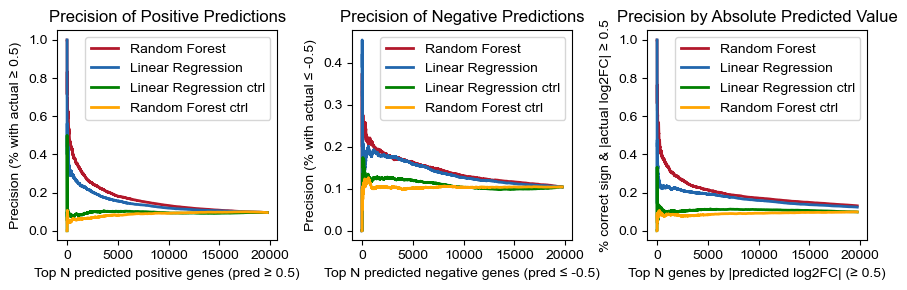

In [23]:
def calculate_overall_precision_curves(results_dict, max_n=1000):
    """
    Calculate precision curves by concatenating results from all random splits with 0.5 threshold
    Uses ALL genes, but TP requires both |predicted| >= 0.5 AND |actual| >= 0.5
    """
    # Get model names from first split
    first_split = list(results_dict.keys())[0]
    model_names = list(results_dict[first_split].keys())
    
    overall_curves = {}
    
    for model_name in model_names:
        # Concatenate data from all splits
        all_pred_log2fc = []
        all_actual_log2fc = []
        all_filter_criteria = []
        
        for split_random_state in results_dict.keys():
            results = results_dict[split_random_state][model_name]
            all_pred_log2fc.extend(results['pred_log2fc'])
            all_actual_log2fc.extend(results['actual_log2fc'])
            all_filter_criteria.extend(results['filter_criteria'])
        
        # Convert to numpy arrays
        all_pred_log2fc = np.array(all_pred_log2fc)
        all_actual_log2fc = np.array(all_actual_log2fc)
        all_filter_criteria = np.array(all_filter_criteria)
        
        # Use ALL genes (no filtering by actual magnitude)
        filtered_pred = all_pred_log2fc
        filtered_actual = all_actual_log2fc
        
        # For positive predictions: only consider genes with predicted >= 0.5
        # pos_mask = filtered_pred >= 0.5
        pos_pred_values = filtered_pred
        pos_actual_values = filtered_actual
        
        # Sort by predicted log2fc in descending order
        pos_sorted_idx = np.argsort(-pos_pred_values)
        pos_pred_sorted = pos_pred_values[pos_sorted_idx]
        pos_actual_sorted = pos_actual_values[pos_sorted_idx]
        
        # For negative predictions: only consider genes with predicted <= -0.5
        # neg_mask = filtered_pred <= -0.5
        neg_pred_values = filtered_pred
        neg_actual_values = filtered_actual
        
        # Sort by predicted log2fc in ascending order
        neg_sorted_idx = np.argsort(neg_pred_values)
        neg_pred_sorted = neg_pred_values[neg_sorted_idx]
        neg_actual_sorted = neg_actual_values[neg_sorted_idx]
        
        # For absolute value predictions - all genes ordered by absolute predicted value
        abs_pred_values = np.abs(filtered_pred)
        abs_actual_values = filtered_actual
        
        # Sort by absolute predicted log2fc in descending order
        abs_sorted_idx = np.argsort(-abs_pred_values)
        abs_actual_sorted = abs_actual_values[abs_sorted_idx]
        abs_pred_sorted = filtered_pred[abs_sorted_idx]
        
        # Calculate precision for different N values
        pos_max_n = min(max_n, len(filtered_pred))
        neg_max_n = min(max_n, len(filtered_pred))
        abs_max_n = min(max_n, len(filtered_pred))
        
        pos_n_values = range(1, pos_max_n + 1)
        neg_n_values = range(1, neg_max_n + 1)
        abs_n_values = range(1, abs_max_n + 1)
        
        pos_precision = []
        neg_precision = []
        abs_precision = []
        
        # For positive genes: TP = actual >= 0.5 (predicted already >= 0.5)
        for n in pos_n_values:
            top_n_pred = pos_pred_sorted[:n]
            top_n_actual = pos_actual_sorted[:n]
            # Predicted already >= 0.5, just check if actual >= 0.5
            tp = top_n_actual >= 0.5
            pos_prec = np.sum(tp) / n
            pos_precision.append(pos_prec)
        
        # For negative genes: TP = actual <= -0.5 (predicted already <= -0.5)
        for n in neg_n_values:
            top_n_pred = neg_pred_sorted[:n]
            top_n_actual = neg_actual_sorted[:n]
            # Predicted already <= -0.5, just check if actual <= -0.5
            tp = top_n_actual <= -0.5
            neg_prec = np.sum(tp) / n
            neg_precision.append(neg_prec)
        
        # For absolute value predictions: TP = correct sign AND both magnitudes >= 0.5
        for n in abs_n_values:
            top_n_pred = abs_pred_sorted[:n]
            top_n_actual = abs_actual_sorted[:n]
            # TP = correct sign AND both magnitudes >= 0.5
            correct_sign = ((top_n_pred > 0) & (top_n_actual > 0)) | \
                          ((top_n_pred < 0) & (top_n_actual < 0))
            both_significant = (np.abs(top_n_actual) >= 0.5)
            tp = correct_sign & both_significant
            abs_prec = np.sum(tp) / n
            abs_precision.append(abs_prec)
        
        overall_curves[model_name] = {
            'pos_n_values': list(pos_n_values),
            'neg_n_values': list(neg_n_values),
            'abs_n_values': list(abs_n_values),
            'pos_precision': pos_precision,
            'neg_precision': neg_precision,
            'abs_precision': abs_precision
        }
    
    return overall_curves


def plot_overall_precision_curves(overall_curves, save_dir=None):
    """
    Plot precision curves from concatenated results across all splits
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
    
    colors = ["#b2182b", "#2166ac", 'green', 'orange', 'purple']
    model_names = list(overall_curves.keys())
    
    # Plot positive predictions precision
    ax1.set_title('Precision of Positive Predictions')
    for i, model_name in enumerate(model_names):
        model_name_to_print = "Linear Regression" if model_name == "lr" else "Random Forest"
        if model_name == "lr_ctrl":
            model_name_to_print = "Linear Regression ctrl"
        if model_name == "rf_ctrl":
            model_name_to_print = "Random Forest ctrl"
        curve = overall_curves[model_name]
        if curve['pos_n_values']:
            ax1.plot(curve['pos_n_values'], 
                     curve['pos_precision'], 
                     color=colors[i % len(colors)], 
                     label=model_name_to_print, 
                     linewidth=2)
    
    ax1.set_xlabel('Top N predicted positive genes (pred ≥ 0.5)')
    ax1.set_ylabel('Precision (% with actual ≥ 0.5)')
    ax1.legend()
    
    # Plot negative predictions precision
    ax2.set_title('Precision of Negative Predictions')
    for i, model_name in enumerate(model_names):
        model_name_to_print = "Linear Regression" if model_name == "lr" else "Random Forest"
        if model_name == "lr_ctrl":
            model_name_to_print = "Linear Regression ctrl"
        if model_name == "rf_ctrl":
            model_name_to_print = "Random Forest ctrl"
        curve = overall_curves[model_name]
        if curve['neg_n_values']:
            ax2.plot(curve['neg_n_values'], curve['neg_precision'], 
                    color=colors[i % len(colors)], label=model_name_to_print, linewidth=2)
    
    ax2.set_xlabel('Top N predicted negative genes (pred ≤ -0.5)')
    ax2.set_ylabel('Precision (% with actual ≤ -0.5)')
    ax2.legend()
    
    # Plot absolute value predictions precision
    ax3.set_title('Precision by Absolute Predicted Value')
    for i, model_name in enumerate(model_names):
        model_name_to_print = "Linear Regression" if model_name == "lr" else "Random Forest"
        if model_name == "lr_ctrl":
            model_name_to_print = "Linear Regression ctrl"
        if model_name == "rf_ctrl":
            model_name_to_print = "Random Forest ctrl"
        curve = overall_curves[model_name]
        if curve['abs_n_values']:
            ax3.plot(curve['abs_n_values'], curve['abs_precision'], 
                    color=colors[i % len(colors)], label=model_name_to_print, linewidth=2)
    
    ax3.set_xlabel('Top N genes by |predicted log2FC| (≥ 0.5)')
    ax3.set_ylabel('% correct sign & |actual log2FC| ≥ 0.5')
    ax3.legend()
    
    plt.tight_layout()
    
    if save_dir:
        import os
        os.makedirs(save_dir, exist_ok=True)
        fig.savefig(os.path.join(save_dir, "overall_precision_curves_threshold05.pdf"), bbox_inches='tight', dpi=300)
    
    plt.show()
    return fig

# Print summary statistics
def print_summary_statistics(results_dict):
    """Print summary statistics from concatenated results across all splits"""
    print("\n=== SUMMARY STATISTICS FROM CONCATENATED RESULTS ===")
    
    first_split = list(results_dict.keys())[0]
    model_names = list(results_dict[first_split].keys())
    
    for model_name in model_names:
        model_name_to_print = "Linear Regression" if model_name == "lr" else "Random Forest"
        if model_name == "lr_ctrl":
            model_name_to_print = "Linear Regression ctrl"
        if model_name == "rf_ctrl":
            model_name_to_print = "Random Forest ctrl"
        print(f"\n{model_name_to_print}:")
        
        # Concatenate all data
        all_pred_log2fc = []
        all_actual_log2fc = []
        all_filter_criteria = []
        
        for split_random_state in results_dict.keys():
            results = results_dict[split_random_state][model_name]
            all_pred_log2fc.extend(results['pred_log2fc'])
            all_actual_log2fc.extend(results['actual_log2fc'])
            all_filter_criteria.extend(results['filter_criteria'])
        
        # Convert to numpy arrays
        all_pred_log2fc = np.array(all_pred_log2fc)
        all_actual_log2fc = np.array(all_actual_log2fc)
        all_filter_criteria = np.array(all_filter_criteria)
        
        # Apply filter and calculate correlations
        filtered_pred = all_pred_log2fc[all_filter_criteria]
        filtered_actual = all_actual_log2fc[all_filter_criteria]
        
        pearson_cor = scipy.stats.pearsonr(filtered_pred, filtered_actual)[0]
        spearman_cor = scipy.stats.spearmanr(filtered_pred, filtered_actual)[0]
        
        print(f"  Total filtered samples: {len(filtered_pred)}")
        print(f"  Pearson correlation: {pearson_cor:.3f}")
        print(f"  Spearman correlation: {spearman_cor:.3f}")


# Calculate overall precision curves from concatenated data
print("Calculating overall precision curves...")
overall_curves = calculate_overall_precision_curves(results_dict, max_n=20000)

# Plot overall precision curves
print("Plotting overall precision curves...")
precision_fig = plot_overall_precision_curves(overall_curves, save_dir=f"/dcs05/hongkai/data/next_cutntag/bulk/explainability/{model_design}/fig/df_vs_df/")

Calculating traditional recall curves (ranked by prediction)...

Traditional Recall Curve Statistics:

Random Forest:
  Total actual positives (≥0.5): 1883
  Total actual negatives (≤-0.5): 2058
  Total actual changed (|≥0.5|): 3941
  Positive: N=5275 to reach 50% recall
  Positive: N=13122 to reach 80% recall
  Negative: N=6824 to reach 50% recall
  Negative: N=13863 to reach 80% recall
  Absolute: N=8022 to reach 50% recall
  Absolute: N=14562 to reach 80% recall

Linear Regression:
  Total actual positives (≥0.5): 1883
  Total actual negatives (≤-0.5): 2058
  Total actual changed (|≥0.5|): 3941
  Positive: N=6781 to reach 50% recall
  Positive: N=14206 to reach 80% recall
  Negative: N=7297 to reach 50% recall
  Negative: N=14440 to reach 80% recall
  Absolute: N=8192 to reach 50% recall
  Absolute: N=14940 to reach 80% recall

Linear Regression ctrl:
  Total actual positives (≥0.5): 1883
  Total actual negatives (≤-0.5): 2058
  Total actual changed (|≥0.5|): 3941
  Positive: N=1010

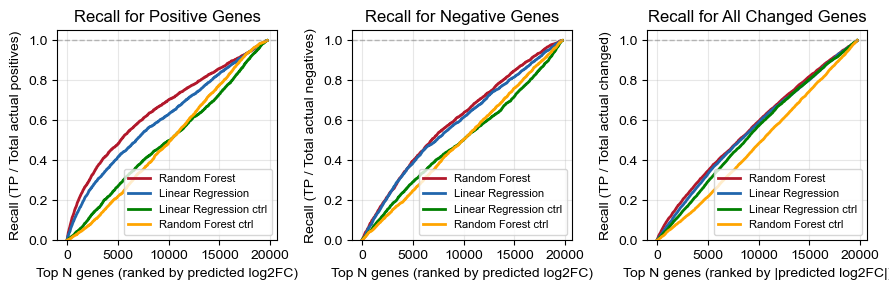

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_traditional_recall_curves(results_dict, max_n=2000):
    """
    Calculate traditional recall curves by ranking all genes by predicted magnitude.
    Recall = TP / P where P is total actual positives (constant), TP increases with N.
    """
    # Get model names from first split
    first_split = list(results_dict.keys())[0]
    model_names = list(results_dict[first_split].keys())
    
    recall_curves = {}
    
    for model_name in model_names:
        # Concatenate data from all splits
        all_pred_log2fc = []
        all_actual_log2fc = []
        
        for split_random_state in results_dict.keys():
            results = results_dict[split_random_state][model_name]
            all_pred_log2fc.extend(results['pred_log2fc'])
            all_actual_log2fc.extend(results['actual_log2fc'])
        
        # Convert to numpy arrays
        all_pred_log2fc = np.array(all_pred_log2fc)
        all_actual_log2fc = np.array(all_actual_log2fc)
        
        # === POSITIVE RECALL CURVE ===
        # P = Total actual positives (actual >= 0.5)
        total_actual_positives = np.sum(all_actual_log2fc >= 0.5)
        
        # Rank all genes by predicted log2FC (descending, most positive first)
        pos_sorted_idx = np.argsort(-all_pred_log2fc)
        pos_pred_sorted = all_pred_log2fc[pos_sorted_idx]
        pos_actual_sorted = all_actual_log2fc[pos_sorted_idx]
        
        # Calculate recall for top N predictions
        pos_max_n = min(max_n, len(all_pred_log2fc))
        pos_n_values = range(1, pos_max_n + 1)
        pos_recall = []
        
        for n in pos_n_values:
            top_n_pred = pos_pred_sorted[:n]
            top_n_actual = pos_actual_sorted[:n]
            # TP: predicted >= 0.5 AND actual >= 0.5 (both have sufficient magnitude)
            tp = np.sum((top_n_actual >= 0.5))
            recall = tp / total_actual_positives if total_actual_positives > 0 else 0
            pos_recall.append(recall)
        
        # === NEGATIVE RECALL CURVE ===
        # P = Total actual negatives (actual <= -0.5)
        total_actual_negatives = np.sum(all_actual_log2fc <= -0.5)
        
        # Rank all genes by predicted log2FC (ascending, most negative first)
        neg_sorted_idx = np.argsort(all_pred_log2fc)
        neg_pred_sorted = all_pred_log2fc[neg_sorted_idx]
        neg_actual_sorted = all_actual_log2fc[neg_sorted_idx]
        
        # Calculate recall for top N predictions
        neg_max_n = min(max_n, len(all_pred_log2fc))
        neg_n_values = range(1, neg_max_n + 1)
        neg_recall = []
        
        for n in neg_n_values:
            top_n_pred = neg_pred_sorted[:n]
            top_n_actual = neg_actual_sorted[:n]
            # TP: predicted <= -0.5 AND actual <= -0.5 (both have sufficient magnitude)
            tp = np.sum((top_n_actual <= -0.5))
            recall = tp / total_actual_negatives if total_actual_negatives > 0 else 0
            neg_recall.append(recall)
        
        # === ABSOLUTE VALUE RECALL CURVE ===
        # P = Total actual changed (|actual| >= 0.5)
        total_actual_changed = np.sum(np.abs(all_actual_log2fc) >= 0.5)
        
        # Rank all genes by |predicted log2FC| (descending)
        abs_sorted_idx = np.argsort(-np.abs(all_pred_log2fc))
        abs_pred_sorted = all_pred_log2fc[abs_sorted_idx]
        abs_actual_sorted = all_actual_log2fc[abs_sorted_idx]
        
        # Calculate recall for top N predictions
        abs_max_n = min(max_n, len(all_pred_log2fc))
        abs_n_values = range(1, abs_max_n + 1)
        abs_recall = []
        
        for n in abs_n_values:
            top_n_pred = abs_pred_sorted[:n]
            top_n_actual = abs_actual_sorted[:n]
            # TP: correct sign AND both magnitudes >= 0.5
            correct_sign = ((top_n_pred > 0) & (top_n_actual > 0)) | \
                          ((top_n_pred < 0) & (top_n_actual < 0))
            both_significant = (np.abs(top_n_actual) >= 0.5) 
            
            tp = np.sum(correct_sign & both_significant)
            # tp=np.sum(both_significant)
            recall = tp / total_actual_changed if total_actual_changed > 0 else 0
            abs_recall.append(recall)
        
        recall_curves[model_name] = {
            'pos_n_values': list(pos_n_values),
            'neg_n_values': list(neg_n_values),
            'abs_n_values': list(abs_n_values),
            'pos_recall': pos_recall,
            'neg_recall': neg_recall,
            'abs_recall': abs_recall,
            'total_actual_positives': total_actual_positives,
            'total_actual_negatives': total_actual_negatives,
            'total_actual_changed': total_actual_changed
        }
    
    return recall_curves

def plot_traditional_recall_curves(recall_curves, save_dir=None):
    """
    Plot traditional recall curves (ranked by prediction, recall = TP/P)
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
    
    colors = ["#b2182b", "#2166ac", 'green', 'orange', 'purple']
    model_names = list(recall_curves.keys())
    
    # Plot positive recall curve
    ax1.set_title('Recall for Positive Genes')
    for i, model_name in enumerate(model_names):
        model_name_to_print = "Linear Regression" if model_name == "lr" else "Random Forest"
        if model_name == "lr_ctrl":
            model_name_to_print = "Linear Regression ctrl"
        if model_name == "rf_ctrl":
            model_name_to_print = "Random Forest ctrl"
        
        curve = recall_curves[model_name]
        total_p = curve['total_actual_positives']
        
        if curve['pos_n_values']:
            ax1.plot(curve['pos_n_values'], 
                     curve['pos_recall'], 
                     color=colors[i % len(colors)], 
                     label=f"{model_name_to_print}", 
                     linewidth=2)
    
    ax1.set_xlabel('Top N genes (ranked by predicted log2FC)')
    ax1.set_ylabel('Recall (TP / Total actual positives)')
    ax1.set_ylim([0, 1.05])
    ax1.axhline(y=1.0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Plot negative recall curve
    ax2.set_title('Recall for Negative Genes')
    for i, model_name in enumerate(model_names):
        model_name_to_print = "Linear Regression" if model_name == "lr" else "Random Forest"
        if model_name == "lr_ctrl":
            model_name_to_print = "Linear Regression ctrl"
        if model_name == "rf_ctrl":
            model_name_to_print = "Random Forest ctrl"
        
        curve = recall_curves[model_name]
        total_p = curve['total_actual_negatives']
        
        if curve['neg_n_values']:
            ax2.plot(curve['neg_n_values'], 
                     curve['neg_recall'], 
                     color=colors[i % len(colors)], 
                     label=f"{model_name_to_print}", 
                     linewidth=2)
    
    ax2.set_xlabel('Top N genes (ranked by predicted log2FC)')
    ax2.set_ylabel('Recall (TP / Total actual negatives)')
    ax2.set_ylim([0, 1.05])
    ax2.axhline(y=1.0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax2.legend(fontsize=8)
    ax2.grid(True, alpha=0.3)
    
    # Plot absolute value recall curve
    ax3.set_title('Recall for All Changed Genes')
    for i, model_name in enumerate(model_names):
        model_name_to_print = "Linear Regression" if model_name == "lr" else "Random Forest"
        if model_name == "lr_ctrl":
            model_name_to_print = "Linear Regression ctrl"
        if model_name == "rf_ctrl":
            model_name_to_print = "Random Forest ctrl"
        
        curve = recall_curves[model_name]
        total_p = curve['total_actual_changed']
        
        if curve['abs_n_values']:
            ax3.plot(curve['abs_n_values'], 
                     curve['abs_recall'], 
                     color=colors[i % len(colors)], 
                     label=f"{model_name_to_print}", 
                     linewidth=2)
    
    ax3.set_xlabel('Top N genes (ranked by |predicted log2FC|)')
    ax3.set_ylabel('Recall (TP / Total actual changed)')
    ax3.set_ylim([0, 1.05])
    ax3.axhline(y=1.0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax3.legend(fontsize=8)
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_dir:
        import os
        os.makedirs(save_dir, exist_ok=True)
        fig.savefig(os.path.join(save_dir, "traditional_recall_curves_threshold05.pdf"), bbox_inches='tight', dpi=300)
        print(f"Saved: {os.path.join(save_dir, 'traditional_recall_curves_threshold05.pdf')}")
    
    plt.show()
    return fig

# Usage example:
print("Calculating traditional recall curves (ranked by prediction)...")
traditional_recall_curves = calculate_traditional_recall_curves(results_dict, max_n=50000)

print("\nTraditional Recall Curve Statistics:")
for model_name, curves in traditional_recall_curves.items():
    model_name_to_print = "Linear Regression" if model_name == "lr" else "Random Forest"
    if model_name == "lr_ctrl":
        model_name_to_print = "Linear Regression ctrl"
    if model_name == "rf_ctrl":
        model_name_to_print = "Random Forest ctrl"
    print(f"\n{model_name_to_print}:")
    print(f"  Total actual positives (≥0.5): {curves['total_actual_positives']}")
    print(f"  Total actual negatives (≤-0.5): {curves['total_actual_negatives']}")
    print(f"  Total actual changed (|≥0.5|): {curves['total_actual_changed']}")
    
    # Find N for different recall thresholds
    for recall_type, recall_list, n_list in [
        ('Positive', curves['pos_recall'], curves['pos_n_values']),
        ('Negative', curves['neg_recall'], curves['neg_n_values']),
        ('Absolute', curves['abs_recall'], curves['abs_n_values'])
    ]:
        recall_50_idx = next((i for i, r in enumerate(recall_list) if r >= 0.5), None)
        recall_80_idx = next((i for i, r in enumerate(recall_list) if r >= 0.8), None)
        
        if recall_50_idx:
            print(f"  {recall_type}: N={n_list[recall_50_idx]} to reach 50% recall")
        if recall_80_idx:
            print(f"  {recall_type}: N={n_list[recall_80_idx]} to reach 80% recall")

print("\nPlotting traditional recall curves...")
traditional_recall_fig = plot_traditional_recall_curves(
    traditional_recall_curves, 
    save_dir=f"/dcs05/hongkai/data/next_cutntag/bulk/explainability/{model_design}/fig/df_vs_df/"
)

Calculating Precision-Recall curves...

Plotting PR curves...
Saved: /dcs05/hongkai/data/next_cutntag/bulk/explainability/rnaseq_vs_hiplex_rm_outlier_log/fig/df_vs_df/pr_curves_threshold05.pdf


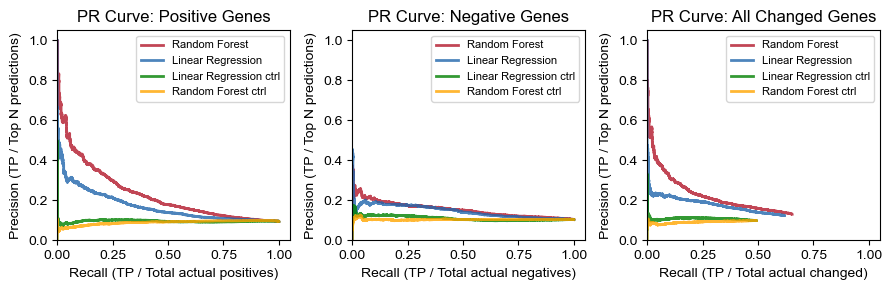


=== AUC-PR Statistics ===

Random Forest:
  Positive AUC-PR: 0.2309
  Negative AUC-PR: 0.1540
  Absolute AUC-PR: 0.1514

Linear Regression:
  Positive AUC-PR: 0.1686
  Negative AUC-PR: 0.1456
  Absolute AUC-PR: 0.1119

Linear Regression ctrl:
  Positive AUC-PR: 0.0950
  Negative AUC-PR: 0.1101
  Absolute AUC-PR: 0.0531

Random Forest ctrl:
  Positive AUC-PR: 0.0887
  Negative AUC-PR: 0.1039
  Absolute AUC-PR: 0.0449


In [43]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_pr_curves(results_dict, max_n=2000):
    """
    Calculate Precision-Recall curves where each point represents (Recall, Precision) at top N.
    Both precision and recall require |predicted| >= 0.5 AND |actual| >= 0.5 for TP.
    """
    # Get model names from first split
    first_split = list(results_dict.keys())[0]
    model_names = list(results_dict[first_split].keys())
    
    pr_curves = {}
    
    for model_name in model_names:
        # Concatenate data from all splits
        all_pred_log2fc = []
        all_actual_log2fc = []
        
        for split_random_state in results_dict.keys():
            results = results_dict[split_random_state][model_name]
            all_pred_log2fc.extend(results['pred_log2fc'])
            all_actual_log2fc.extend(results['actual_log2fc'])
        
        # Convert to numpy arrays
        all_pred_log2fc = np.array(all_pred_log2fc)
        all_actual_log2fc = np.array(all_actual_log2fc)
        
        # === POSITIVE PR CURVE ===
        # P = Total actual positives (actual >= 0.5) - constant for recall
        total_actual_positives = np.sum(all_actual_log2fc >= 0.5)
        # total_pred_positives = np.sum(all_pred_log2fc >= 0.5)
        # Rank all genes by predicted log2FC (descending)
        pos_sorted_idx = np.argsort(-all_pred_log2fc)
        pos_pred_sorted = all_pred_log2fc[pos_sorted_idx]
        pos_actual_sorted = all_actual_log2fc[pos_sorted_idx]
        
        # Calculate precision and recall for each N
        pos_max_n = min(max_n, len(all_actual_log2fc))
        pos_n_values = range(1, pos_max_n + 1)
        pos_precision = []
        pos_recall = []
        
        for n in pos_n_values:
            top_n_pred = pos_pred_sorted[:n]
            top_n_actual = pos_actual_sorted[:n]
            
            # TP: predicted >= 0.5 AND actual >= 0.5
            tp = np.sum((top_n_actual >= 0.5))
            
            # Precision = TP / N (top N predictions)
            precision = tp / n if n > 0 else 0
            
            # Recall = TP / P (total actual positives)
            recall = tp / total_actual_positives if total_actual_positives > 0 else 0
            
            pos_precision.append(precision)
            pos_recall.append(recall)
        
        # === NEGATIVE PR CURVE ===
        # P = Total actual negatives (actual <= -0.5)
        total_actual_negatives = np.sum(all_actual_log2fc <= -0.5)
        # total_pred_negatives = np.sum(all_pred_log2fc <= -0.5)
        # Rank all genes by predicted log2FC (ascending, most negative first)
        neg_sorted_idx = np.argsort(all_pred_log2fc)
        neg_pred_sorted = all_pred_log2fc[neg_sorted_idx]
        neg_actual_sorted = all_actual_log2fc[neg_sorted_idx]
        
        # Calculate precision and recall for each N
        neg_max_n = min(max_n, len(all_actual_log2fc))
        neg_n_values = range(1, neg_max_n + 1)
        neg_precision = []
        neg_recall = []
        
        for n in neg_n_values:
            top_n_pred = neg_pred_sorted[:n]
            top_n_actual = neg_actual_sorted[:n]
            
            # TP: predicted <= -0.5 AND actual <= -0.5
            tp = np.sum((top_n_actual <= -0.5))
            
            # Precision = TP / N
            precision = tp / n if n > 0 else 0
            
            # Recall = TP / P
            recall = tp / total_actual_negatives if total_actual_negatives > 0 else 0
            
            neg_precision.append(precision)
            neg_recall.append(recall)
        
        # === ABSOLUTE VALUE PR CURVE ===
        # P = Total actual changed (|actual| >= 0.5)
        total_actual_changed = np.sum(np.abs(all_actual_log2fc) >= 0.5)
        
        # Rank all genes by |predicted log2FC| (descending)
        abs_sorted_idx = np.argsort(-np.abs(all_pred_log2fc))
        abs_pred_sorted = all_pred_log2fc[abs_sorted_idx]
        abs_actual_sorted = all_actual_log2fc[abs_sorted_idx]
        
        # Calculate precision and recall for each N
        abs_max_n = min(max_n, len(all_pred_log2fc))
        abs_n_values = range(1, abs_max_n + 1)
        abs_precision = []
        abs_recall = []
        
        for n in abs_n_values:
            top_n_pred = abs_pred_sorted[:n]
            top_n_actual = abs_actual_sorted[:n]
            
            # TP: correct sign AND both magnitudes >= 0.5
            correct_sign = ((top_n_pred > 0) & (top_n_actual > 0)) | \
                          ((top_n_pred < 0) & (top_n_actual < 0))
            both_significant = ((np.abs(top_n_actual) >= 0.5))
            tp = np.sum(correct_sign & both_significant)
            
            # Precision = TP / N
            precision = tp / n if n > 0 else 0
            
            # Recall = TP / P
            recall = tp / total_actual_changed if total_actual_changed > 0 else 0
            
            abs_precision.append(precision)
            abs_recall.append(recall)
        
        pr_curves[model_name] = {
            'pos_precision': pos_precision,
            'pos_recall': pos_recall,
            'neg_precision': neg_precision,
            'neg_recall': neg_recall,
            'abs_precision': abs_precision,
            'abs_recall': abs_recall,
            'total_actual_positives': total_actual_positives,
            'total_actual_negatives': total_actual_negatives,
            'total_actual_changed': total_actual_changed
        }
    
    return pr_curves

def plot_pr_curves(pr_curves, save_dir=None):
    """
    Plot Precision-Recall curves (Y=Precision, X=Recall)
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
    
    colors = ["#b2182b", "#2166ac", 'green', 'orange', 'purple']
    model_names = list(pr_curves.keys())
    
    # Plot positive PR curve
    ax1.set_title('PR Curve: Positive Genes')
    for i, model_name in enumerate(model_names):
        model_name_to_print = "Linear Regression" if model_name == "lr" else "Random Forest"
        if model_name == "lr_ctrl":
            model_name_to_print = "Linear Regression ctrl"
        if model_name == "rf_ctrl":
            model_name_to_print = "Random Forest ctrl"
        
        curve = pr_curves[model_name]
        
        # Plot Precision (Y) vs Recall (X)
        ax1.plot(curve['pos_recall'], 
                 curve['pos_precision'], 
                 color=colors[i % len(colors)], 
                 label=model_name_to_print, 
                 linewidth=2,
                 alpha=0.8)
    
    ax1.set_xlabel('Recall (TP / Total actual positives)')
    ax1.set_ylabel('Precision (TP / Top N predictions)')
    ax1.set_xlim([0, 1.05])
    ax1.set_ylim([0, 1.05])
    ax1.legend(fontsize=8)
    # ax1.grid(True, alpha=0.3)
    
    # Plot negative PR curve
    ax2.set_title('PR Curve: Negative Genes')
    for i, model_name in enumerate(model_names):
        model_name_to_print = "Linear Regression" if model_name == "lr" else "Random Forest"
        if model_name == "lr_ctrl":
            model_name_to_print = "Linear Regression ctrl"
        if model_name == "rf_ctrl":
            model_name_to_print = "Random Forest ctrl"
        
        curve = pr_curves[model_name]
        
        ax2.plot(curve['neg_recall'], 
                 curve['neg_precision'], 
                 color=colors[i % len(colors)], 
                 label=model_name_to_print, 
                 linewidth=2,
                 alpha=0.8)
    
    ax2.set_xlabel('Recall (TP / Total actual negatives)')
    ax2.set_ylabel('Precision (TP / Top N predictions)')
    ax2.set_xlim([0, 1.05])
    ax2.set_ylim([0, 1.05])
    ax2.legend(fontsize=8)
    # ax2.grid(True, alpha=0.3)
    
    # Plot absolute value PR curve
    ax3.set_title('PR Curve: All Changed Genes')
    for i, model_name in enumerate(model_names):
        model_name_to_print = "Linear Regression" if model_name == "lr" else "Random Forest"
        if model_name == "lr_ctrl":
            model_name_to_print = "Linear Regression ctrl"
        if model_name == "rf_ctrl":
            model_name_to_print = "Random Forest ctrl"
        
        curve = pr_curves[model_name]
        
        ax3.plot(curve['abs_recall'], 
                 curve['abs_precision'], 
                 color=colors[i % len(colors)], 
                 label=model_name_to_print, 
                 linewidth=2,
                 alpha=0.8)
    
    ax3.set_xlabel('Recall (TP / Total actual changed)')
    ax3.set_ylabel('Precision (TP / Top N predictions)')
    ax3.set_xlim([0, 1.05])
    ax3.set_ylim([0, 1.05])
    ax3.legend(fontsize=8)
    # ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_dir:
        import os
        os.makedirs(save_dir, exist_ok=True)
        fig.savefig(os.path.join(save_dir, "pr_curves_threshold05.pdf"), bbox_inches='tight', dpi=300)
        print(f"Saved: {os.path.join(save_dir, 'pr_curves_threshold05.pdf')}")
    
    plt.show()
    return fig

def calculate_auc_pr(pr_curves):
    """
    Calculate Area Under PR Curve using trapezoidal rule
    """
    print("\n=== AUC-PR Statistics ===")
    
    for model_name, curves in pr_curves.items():
        model_name_to_print = "Linear Regression" if model_name == "lr" else "Random Forest"
        if model_name == "lr_ctrl":
            model_name_to_print = "Linear Regression ctrl"
        if model_name == "rf_ctrl":
            model_name_to_print = "Random Forest ctrl"
        
        print(f"\n{model_name_to_print}:")
        
        # Calculate AUC for each curve type
        for curve_type, recall_key, precision_key in [
            ('Positive', 'pos_recall', 'pos_precision'),
            ('Negative', 'neg_recall', 'neg_precision'),
            ('Absolute', 'abs_recall', 'abs_precision')
        ]:
            recall = np.array(curves[recall_key])
            precision = np.array(curves[precision_key])
            
            # Sort by recall for proper AUC calculation
            sorted_idx = np.argsort(recall)
            recall_sorted = recall[sorted_idx]
            precision_sorted = precision[sorted_idx]
            
            # Calculate AUC using trapezoidal rule
            auc = np.trapz(precision_sorted, recall_sorted)
            
            print(f"  {curve_type} AUC-PR: {auc:.4f}")

# Usage example:
print("Calculating Precision-Recall curves...")
pr_curves = calculate_pr_curves(results_dict, max_n=20000)

print("\nPlotting PR curves...")
pr_fig = plot_pr_curves(
    pr_curves, 
    save_dir=f"/dcs05/hongkai/data/next_cutntag/bulk/explainability/{model_design}/fig/df_vs_df/"
)

# Calculate and print AUC-PR
calculate_auc_pr(pr_curves)

Calculating threshold-varying PR curves...

Plotting threshold-varying PR curves...
Saved: /dcs05/hongkai/data/next_cutntag/bulk/explainability/rnaseq_vs_hiplex_rm_outlier_log/fig/df_vs_df/pr_curves_varying_threshold.pdf


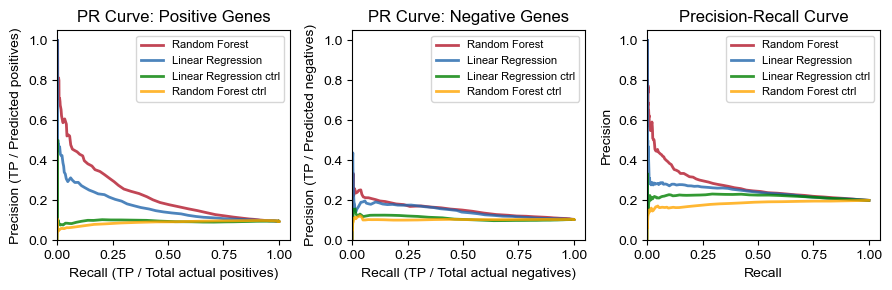


=== Threshold-Varying PR Curve Statistics ===

Random Forest:
  Total actual positives (≥0.5): 1883
  Total actual negatives (≤-0.5): 2058
  Total actual changed (|≥0.5|): 3941

  Positive - Best F1 threshold:
    Threshold: 0.489
    Precision: 0.234
    Recall: 0.370
    F1 Score: 0.286
    AUC-PR: 0.2309

  Negative - Best F1 threshold:
    Threshold: 0.111
    Precision: 0.152
    Recall: 0.495
    F1 Score: 0.232
    AUC-PR: 0.1540

  Absolute - Best F1 threshold:
    Threshold: 0.180
    Precision: 0.225
    Recall: 0.710
    F1 Score: 0.341
    AUC-PR: 0.2753

Linear Regression:
  Total actual positives (≥0.5): 1883
  Total actual negatives (≤-0.5): 2058
  Total actual changed (|≥0.5|): 3941

  Positive - Best F1 threshold:
    Threshold: 0.596
    Precision: 0.196
    Recall: 0.291
    F1 Score: 0.234
    AUC-PR: 0.1687

  Negative - Best F1 threshold:
    Threshold: 0.399
    Precision: 0.154
    Recall: 0.436
    F1 Score: 0.227
    AUC-PR: 0.1457

  Absolute - Best F1 thres

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_threshold_varying_pr_curves(results_dict, num_thresholds=100):
    """
    Calculate Precision-Recall curves by varying the prediction threshold.
    At each threshold, classify genes as positive if |predicted| >= threshold.
    TP requires both |predicted| >= threshold AND |actual| >= 0.5.
    """
    # Get model names from first split
    first_split = list(results_dict.keys())[0]
    model_names = list(results_dict[first_split].keys())
    
    pr_curves = {}
    
    for model_name in model_names:
        # Concatenate data from all splits
        all_pred_log2fc = []
        all_actual_log2fc = []
        
        for split_random_state in results_dict.keys():
            results = results_dict[split_random_state][model_name]
            all_pred_log2fc.extend(results['pred_log2fc'])
            all_actual_log2fc.extend(results['actual_log2fc'])
        
        # Convert to numpy arrays
        all_pred_log2fc = np.array(all_pred_log2fc)
        all_actual_log2fc = np.array(all_actual_log2fc)
        
        # Generate thresholds to test (from 0 to max prediction value)
        max_pred = max(np.max(all_pred_log2fc), np.abs(np.min(all_pred_log2fc)))
        thresholds = np.linspace(0, max_pred, num_thresholds)
        positive_thresholds = np.linspace(np.min(all_pred_log2fc), max_pred, num_thresholds)
        negative_thresholds = np.linspace(np.min(all_pred_log2fc), max_pred, num_thresholds)
        
        # === POSITIVE PR CURVE (varying threshold) ===
        # P = Total actual positives (constant)
        total_actual_positives = np.sum(all_actual_log2fc >= 0.5)
        
        pos_precision = []
        pos_recall = []
        pos_thresholds = []
        
        for threshold in positive_thresholds:
            # Predicted positive: genes with predicted >= threshold
            pred_positive = all_pred_log2fc >= threshold
            n_pred_positive = np.sum(pred_positive)
            
            if n_pred_positive == 0:
                continue  # Skip if no predictions at this threshold
            
            # TP: predicted >= threshold AND actual >= 0.5
            tp = np.sum(pred_positive & (all_actual_log2fc >= 0.5))
            
            # Precision = TP / (all predicted positive)
            precision = tp / n_pred_positive
            
            # Recall = TP / (all actual positive)
            recall = tp / total_actual_positives if total_actual_positives > 0 else 0
            
            pos_precision.append(precision)
            pos_recall.append(recall)
            pos_thresholds.append(threshold)

        # === NEGATIVE PR CURVE (varying threshold) ===
        # P = Total actual negatives (constant)
        total_actual_negatives = np.sum(all_actual_log2fc <= -0.5)
        
        neg_precision = []
        neg_recall = []
        neg_thresholds = []
        
        for threshold in negative_thresholds:
            # Predicted negative: genes with predicted <= -threshold
            pred_negative = all_pred_log2fc <= -threshold
            n_pred_negative = np.sum(pred_negative)
            
            if n_pred_negative == 0:
                continue  # Skip if no predictions at this threshold
            
            # TP: predicted <= -threshold AND actual <= -0.5
            tp = np.sum(pred_negative & (all_actual_log2fc <= -0.5))
            
            # Precision = TP / (all predicted negative)
            precision = tp / n_pred_negative
            
            # Recall = TP / (all actual negative)
            recall = tp / total_actual_negatives if total_actual_negatives > 0 else 0
            
            neg_precision.append(precision)
            neg_recall.append(recall)
            neg_thresholds.append(threshold)
        
        # === ABSOLUTE VALUE PR CURVE (varying threshold) ===
        # P = Total actual changed (constant)
        total_actual_changed = np.sum(np.abs(all_actual_log2fc) >= 0.5)
        
        abs_precision = []
        abs_recall = []
        abs_thresholds = []
        
        for threshold in thresholds:
            # Predicted changed: genes with |predicted| >= threshold
            pred_changed = np.abs(all_pred_log2fc) >= threshold
            n_pred_changed = np.sum(pred_changed)
            
            if n_pred_changed == 0:
                continue  # Skip if no predictions at this threshold
            
            # Get predicted and actual values for predicted changed genes
            pred_vals = all_pred_log2fc[pred_changed]
            actual_vals = all_actual_log2fc[pred_changed]
            
            # TP: correct sign AND |actual| >= 0.5 AND |predicted| >= threshold
            correct_sign = ((pred_vals > 0) & (actual_vals > 0)) | \
                          ((pred_vals < 0) & (actual_vals < 0))
            actual_significant = np.abs(actual_vals) >= 0.5
            # tp = np.sum(correct_sign & actual_significant)
            tp = np.sum(actual_significant)
            # Precision = TP / (all predicted changed)
            # precision = np.sum(correct_sign & actual_significant) / n_pred_changed
            precision = tp / n_pred_changed
            # Recall = TP / (all actual changed)
            recall = tp / total_actual_changed if total_actual_changed > 0 else 0
            
            abs_precision.append(precision)
            abs_recall.append(recall)
            abs_thresholds.append(threshold)
        # print(model_name)
        # print(abs_precision)
        # print(abs_recall)
        # print(abs_thresholds)
        pr_curves[model_name] = {
            'pos_precision': np.array(pos_precision),
            'pos_recall': np.array(pos_recall),
            'pos_thresholds': np.array(pos_thresholds),
            'neg_precision': np.array(neg_precision),
            'neg_recall': np.array(neg_recall),
            'neg_thresholds': np.array(neg_thresholds),
            'abs_precision': np.array(abs_precision),
            'abs_recall': np.array(abs_recall),
            'abs_thresholds': np.array(abs_thresholds),
            'total_actual_positives': total_actual_positives,
            'total_actual_negatives': total_actual_negatives,
            'total_actual_changed': total_actual_changed
        }
    
    return pr_curves

def plot_threshold_varying_pr_curves(pr_curves, save_dir=None):
    """
    Plot Precision-Recall curves with varying prediction threshold (Y=Precision, X=Recall)
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
    
    colors = ["#b2182b", "#2166ac", 'green', 'orange', 'purple']
    model_names = list(pr_curves.keys())
    
    # Plot positive PR curve
    ax1.set_title('PR Curve: Positive Genes')
    for i, model_name in enumerate(model_names):
        model_name_to_print = "Linear Regression" if model_name == "lr" else "Random Forest"
        if model_name == "lr_ctrl":
            model_name_to_print = "Linear Regression ctrl"
        if model_name == "rf_ctrl":
            model_name_to_print = "Random Forest ctrl"
        
        curve = pr_curves[model_name]
        
        # Sort by recall for smooth curve
        sort_idx = np.argsort(curve['pos_recall'])
        recall_sorted = curve['pos_recall'][sort_idx]
        precision_sorted = curve['pos_precision'][sort_idx]
        
        # Calculate AUC
        auc_val = np.trapz(precision_sorted, recall_sorted)
        
        # Plot Precision (Y) vs Recall (X)
        ax1.plot(recall_sorted, 
                 precision_sorted, 
                 color=colors[i % len(colors)], 
                 label=f"{model_name_to_print}", 
                 linewidth=2,
                 alpha=0.8)
    
    ax1.set_xlabel('Recall (TP / Total actual positives)')
    ax1.set_ylabel('Precision (TP / Predicted positives)')
    ax1.set_xlim([0, 1.05])
    ax1.set_ylim([0, 1.05])
    ax1.legend(fontsize=8, loc='best')
    # ax1.grid(True, alpha=0.3)
    
    # Add diagonal reference line (random classifier)
    baseline_pos = pr_curves[model_names[0]]['total_actual_positives'] / len(pr_curves[model_names[0]]['pos_recall'])
    # ax1.axhline(y=baseline_pos, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Random')
    
    # Plot negative PR curve
    ax2.set_title('PR Curve: Negative Genes')
    for i, model_name in enumerate(model_names):
        model_name_to_print = "Linear Regression" if model_name == "lr" else "Random Forest"
        if model_name == "lr_ctrl":
            model_name_to_print = "Linear Regression ctrl"
        if model_name == "rf_ctrl":
            model_name_to_print = "Random Forest ctrl"
        
        curve = pr_curves[model_name]
        
        # Sort by recall for smooth curve
        sort_idx = np.argsort(curve['neg_recall'])
        recall_sorted = curve['neg_recall'][sort_idx]
        precision_sorted = curve['neg_precision'][sort_idx]
        
        # Calculate AUC
        auc_val = np.trapz(precision_sorted, recall_sorted)
        
        ax2.plot(recall_sorted, 
                 precision_sorted, 
                 color=colors[i % len(colors)], 
                 label=f"{model_name_to_print}", 
                 linewidth=2,
                 alpha=0.8)
    
    ax2.set_xlabel('Recall (TP / Total actual negatives)')
    ax2.set_ylabel('Precision (TP / Predicted negatives)')
    ax2.set_xlim([0, 1.05])
    ax2.set_ylim([0, 1.05])
    ax2.legend(fontsize=8, loc='best')
    # ax2.grid(True, alpha=0.3)
    
    # Plot absolute value PR curve
    ax3.set_title('Precision-Recall Curve')
    for i, model_name in enumerate(model_names):
        model_name_to_print = "Linear Regression" if model_name == "lr" else "Random Forest"
        if model_name == "lr_ctrl":
            model_name_to_print = "Linear Regression ctrl"
        if model_name == "rf_ctrl":
            model_name_to_print = "Random Forest ctrl"
        
        curve = pr_curves[model_name]
        
        # Sort by recall for smooth curve
        sort_idx = np.argsort(curve['abs_recall'])
        recall_sorted = curve['abs_recall'][sort_idx]
        precision_sorted = curve['abs_precision'][sort_idx]
        
        # Calculate AUC
        auc_val = np.trapz(precision_sorted, recall_sorted)
        
        ax3.plot(recall_sorted, 
                 precision_sorted, 
                 color=colors[i % len(colors)], 
                 label=f"{model_name_to_print}", 
                 linewidth=2,
                 alpha=0.8)
    
    ax3.set_xlabel('Recall')
    ax3.set_ylabel('Precision')
    ax3.set_xlim([0, 1.05])
    ax3.set_ylim([0, 1.05])
    ax3.legend(fontsize=8, loc='best')
    # ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_dir:
        import os
        os.makedirs(save_dir, exist_ok=True)
        fig.savefig(os.path.join(save_dir, "pr_curves_varying_threshold.pdf"), bbox_inches='tight', dpi=300)
        print(f"Saved: {os.path.join(save_dir, 'pr_curves_varying_threshold.pdf')}")
    
    plt.show()
    return fig

def print_threshold_statistics(pr_curves):
    """
    Print key statistics about threshold-based PR curves
    """
    print("\n=== Threshold-Varying PR Curve Statistics ===")
    
    for model_name, curves in pr_curves.items():
        model_name_to_print = "Linear Regression" if model_name == "lr" else "Random Forest"
        if model_name == "lr_ctrl":
            model_name_to_print = "Linear Regression ctrl"
        if model_name == "rf_ctrl":
            model_name_to_print = "Random Forest ctrl"
        
        print(f"\n{model_name_to_print}:")
        print(f"  Total actual positives (≥0.5): {curves['total_actual_positives']}")
        print(f"  Total actual negatives (≤-0.5): {curves['total_actual_negatives']}")
        print(f"  Total actual changed (|≥0.5|): {curves['total_actual_changed']}")
        
        # Find optimal thresholds (F1 score maximization)
        for curve_type, precision_key, recall_key, threshold_key in [
            ('Positive', 'pos_precision', 'pos_recall', 'pos_thresholds'),
            ('Negative', 'neg_precision', 'neg_recall', 'neg_thresholds'),
            ('Absolute', 'abs_precision', 'abs_recall', 'abs_thresholds')
        ]:
            precision = curves[precision_key]
            recall = curves[recall_key]
            thresholds = curves[threshold_key]
            
            if len(precision) > 0:
                # F1 score = 2 * (precision * recall) / (precision + recall)
                f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
                best_idx = np.argmax(f1_scores)
                
                print(f"\n  {curve_type} - Best F1 threshold:")
                print(f"    Threshold: {thresholds[best_idx]:.3f}")
                print(f"    Precision: {precision[best_idx]:.3f}")
                print(f"    Recall: {recall[best_idx]:.3f}")
                print(f"    F1 Score: {f1_scores[best_idx]:.3f}")
                
                # AUC-PR
                sort_idx = np.argsort(recall)
                auc_val = np.trapz(precision[sort_idx], recall[sort_idx])
                print(f"    AUC-PR: {auc_val:.4f}")

# Usage example:
print("Calculating threshold-varying PR curves...")
threshold_pr_curves = calculate_threshold_varying_pr_curves(results_dict, num_thresholds=100)

print("\nPlotting threshold-varying PR curves...")
threshold_pr_fig = plot_threshold_varying_pr_curves(
    threshold_pr_curves, 
    save_dir=f"/dcs05/hongkai/data/next_cutntag/bulk/explainability/{model_design}/fig/df_vs_df/"
)

# Print statistics including optimal thresholds
print_threshold_statistics(threshold_pr_curves)

In [ ]:
same_direction = np.sign(filtered_actual) == np.sign(filtered_pred)
y_scores_combined = np.where(same_direction, 
                           np.abs(filtered_pred),    # Reward correct direction
                           -np.abs(filtered_pred))   # Penalize wrong direction

In [25]:
model_name = "rf"
threshold = 0
# Concatenate all data from all splits
all_pred_log2fc = []
all_actual_log2fc = []
all_filter_criteria = []

for split_random_state in results_dict.keys():
    results = results_dict[split_random_state][model_name]
    all_pred_log2fc.extend(results['pred_log2fc'])
    all_actual_log2fc.extend(results['actual_log2fc'])
    all_filter_criteria.extend(results['filter_criteria'])

# Convert to numpy arrays
all_pred_log2fc = np.array(all_pred_log2fc)
all_actual_log2fc = np.array(all_actual_log2fc)
all_filter_criteria = np.array(all_filter_criteria)

# Apply filter criteria
# filtered_pred = all_pred_log2fc[all_filter_criteria]
# filtered_actual = all_actual_log2fc[all_filter_criteria]
filtered_pred = all_pred_log2fc
filtered_actual = all_actual_log2fc

# Binary classification for upregulation (positive class)
y_true_up = (filtered_actual > threshold).astype(int)
y_scores_up = filtered_pred  # Use continuous predictions as scores

# Binary classification for downregulation (negative class)
y_true_down = (filtered_actual < -threshold).astype(int)
y_scores_down = -filtered_pred  # Negative predictions for downregulation

# NEW: Combined classification - any significant change vs no change
# Any significant change (either direction) 
y_true_combined = (np.abs(filtered_actual) > threshold).astype(int)

Please import `gaussian_kde` from the `scipy.stats` namespace; the `scipy.stats.kde` namespace is deprecated and will be removed in SciPy 2.0.0.


Calculating classification metrics...
Plotting ROC curves...


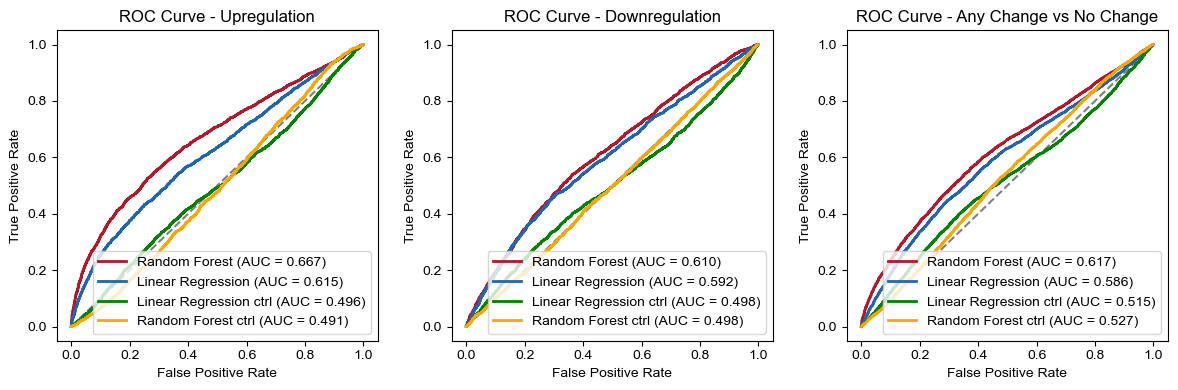

Plotting Precision-Recall curves...


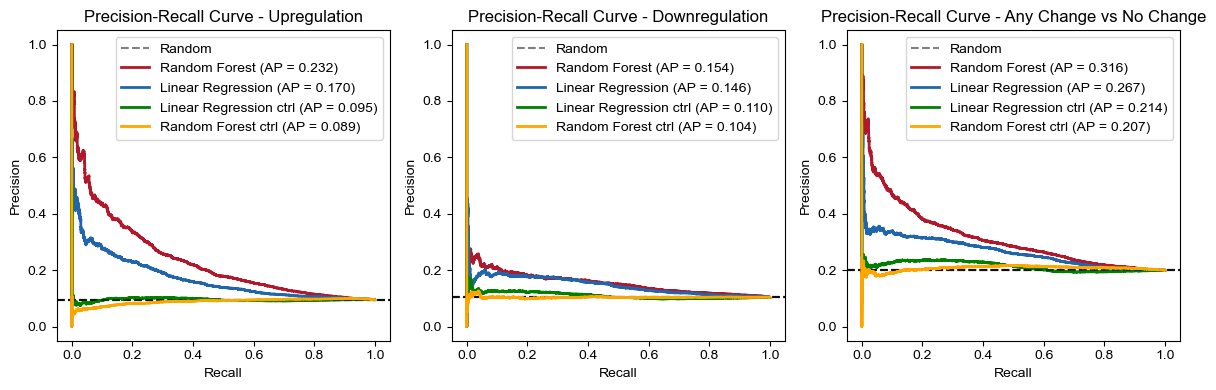


=== CLASSIFICATION METRICS SUMMARY ===

Random Forest:
  Upregulation:
    ROC AUC: 0.667
    PR AUC (Average Precision): 0.232
    Positive samples: 1883/19718
  Downregulation:
    ROC AUC: 0.610
    PR AUC (Average Precision): 0.154
    Positive samples: 2058/19718
  Combined (Any Change vs No Change):
    ROC AUC: 0.617
    PR AUC (Average Precision): 0.316
    Positive samples: 3941/19718

Linear Regression:
  Upregulation:
    ROC AUC: 0.615
    PR AUC (Average Precision): 0.170
    Positive samples: 1883/19718
  Downregulation:
    ROC AUC: 0.592
    PR AUC (Average Precision): 0.146
    Positive samples: 2058/19718
  Combined (Any Change vs No Change):
    ROC AUC: 0.586
    PR AUC (Average Precision): 0.267
    Positive samples: 3941/19718

Linear Regression ctrl:
  Upregulation:
    ROC AUC: 0.496
    PR AUC (Average Precision): 0.095
    Positive samples: 1883/19718
  Downregulation:
    ROC AUC: 0.498
    PR AUC (Average Precision): 0.110
    Positive samples: 2058/19718
 

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.kde import gaussian_kde
import scipy.stats
from scipy.stats import fisher_exact
import pandas as pd
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

def calculate_classification_metrics(results_dict, threshold=0.5):
    """
    Calculate ROC AUC and Precision-Recall metrics for binary classification
    """
    first_split = list(results_dict.keys())[0]
    model_names = list(results_dict[first_split].keys())
    
    classification_results = {}
    
    for model_name in model_names:
        # Concatenate all data from all splits
        all_pred_log2fc = []
        all_actual_log2fc = []
        all_filter_criteria = []
        
        for split_random_state in results_dict.keys():
            results = results_dict[split_random_state][model_name]
            all_pred_log2fc.extend(results['pred_log2fc'])
            all_actual_log2fc.extend(results['actual_log2fc'])
            all_filter_criteria.extend(results['filter_criteria'])
        
        # Convert to numpy arrays
        all_pred_log2fc = np.array(all_pred_log2fc)
        all_actual_log2fc = np.array(all_actual_log2fc)
        all_filter_criteria = np.array(all_filter_criteria)
        
        # Apply filter criteria
        # filtered_pred = all_pred_log2fc[all_filter_criteria]
        # filtered_actual = all_actual_log2fc[all_filter_criteria]
        filtered_pred = all_pred_log2fc
        filtered_actual = all_actual_log2fc
        
        # Binary classification for upregulation (positive class)
        y_true_up = (filtered_actual > threshold).astype(int)
        y_scores_up = filtered_pred  # Use continuous predictions as scores
        
        # Binary classification for downregulation (negative class)
        y_true_down = (filtered_actual < -threshold).astype(int)
        y_scores_down = -filtered_pred  # Negative predictions for downregulation
        
        # NEW: Combined classification - any significant change vs no change
        # Any significant change (either direction) 
        y_true_combined = (np.abs(filtered_actual) > threshold).astype(int)
        
        # Score = predicted_magnitude * directional_agreement
        # Directional agreement: +1 if same sign, -1 if different sign, 0 if one is zero
        # directional_agreement = np.sign(filtered_actual) * np.sign(filtered_pred)
        # y_scores_combined = np.abs(filtered_pred) * directional_agreement
        same_direction = np.sign(filtered_actual) == np.sign(filtered_pred)
        y_scores_combined = np.where(same_direction, 
                                   np.abs(filtered_pred),    # Reward correct direction
                                   -np.abs(filtered_pred))   # Penalize wrong direction
        
        
        # Calculate ROC curves and AUC
        fpr_up, tpr_up, _ = roc_curve(y_true_up, y_scores_up)
        roc_auc_up = auc(fpr_up, tpr_up)
        
        fpr_down, tpr_down, _ = roc_curve(y_true_down, y_scores_down)
        roc_auc_down = auc(fpr_down, tpr_down)
        
        fpr_combined, tpr_combined, _ = roc_curve(y_true_combined, y_scores_combined)
        roc_auc_combined = auc(fpr_combined, tpr_combined)
        
        # Calculate Precision-Recall curves
        precision_up, recall_up, _ = precision_recall_curve(y_true_up, y_scores_up)
        pr_auc_up = average_precision_score(y_true_up, y_scores_up)
        
        precision_down, recall_down, _ = precision_recall_curve(y_true_down, y_scores_down)
        pr_auc_down = average_precision_score(y_true_down, y_scores_down)
        
        precision_combined, recall_combined, _ = precision_recall_curve(y_true_combined, y_scores_combined)
        pr_auc_combined = average_precision_score(y_true_combined, y_scores_combined)
        
        classification_results[model_name] = {
            'upregulation': {
                'fpr': fpr_up,
                'tpr': tpr_up,
                'roc_auc': roc_auc_up,
                'precision': precision_up,
                'recall': recall_up,
                'pr_auc': pr_auc_up,
                'y_true': y_true_up,
                'y_scores': y_scores_up
            },
            'downregulation': {
                'fpr': fpr_down,
                'tpr': tpr_down,
                'roc_auc': roc_auc_down,
                'precision': precision_down,
                'recall': recall_down,
                'pr_auc': pr_auc_down,
                'y_true': y_true_down,
                'y_scores': y_scores_down
            },
            'combined': {
                'fpr': fpr_combined,
                'tpr': tpr_combined,
                'roc_auc': roc_auc_combined,
                'precision': precision_combined,
                'recall': recall_combined,
                'pr_auc': pr_auc_combined,
                'y_true': y_true_combined,
                'y_scores': y_scores_combined
            }
        }
    
    return classification_results

def plot_roc_curves(classification_results, save_dir=None):
    """
    Plot ROC curves for upregulation, downregulation, and combined
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    
    colors = ["#b2182b", "#2166ac", 'green', 'orange', 'purple']
    model_names = list(classification_results.keys())
    
    # Plot ROC for upregulation
    ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    for i, model_name in enumerate(model_names):
        model_name_to_print = "Linear Regression" if model_name == "lr" else "Random Forest"
        if model_name == "lr_ctrl":
            model_name_to_print = "Linear Regression ctrl"
        if model_name == "rf_ctrl":
            model_name_to_print = "Random Forest ctrl"
        results = classification_results[model_name]['upregulation']
        ax1.plot(results['fpr'], results['tpr'], 
                color=colors[i % len(colors)], linewidth=2,
                label=f'{model_name_to_print} (AUC = {results["roc_auc"]:.3f})')
    
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve - Upregulation')
    ax1.legend()
    
    # Plot ROC for downregulation
    ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    for i, model_name in enumerate(model_names):
        model_name_to_print = "Linear Regression" if model_name == "lr" else "Random Forest"
        if model_name == "lr_ctrl":
            model_name_to_print = "Linear Regression ctrl"
        if model_name == "rf_ctrl":
            model_name_to_print = "Random Forest ctrl"
        results = classification_results[model_name]['downregulation']
        ax2.plot(results['fpr'], results['tpr'], 
                color=colors[i % len(colors)], linewidth=2,
                label=f'{model_name_to_print} (AUC = {results["roc_auc"]:.3f})')
    
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve - Downregulation')
    ax2.legend()
    
    # NEW: Plot ROC for combined (any change vs no change)
    ax3.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    for i, model_name in enumerate(model_names):
        model_name_to_print = "Linear Regression" if model_name == "lr" else "Random Forest"
        if model_name == "lr_ctrl":
            model_name_to_print = "Linear Regression ctrl"
        if model_name == "rf_ctrl":
            model_name_to_print = "Random Forest ctrl"
        results = classification_results[model_name]['combined']
        ax3.plot(results['fpr'], results['tpr'], 
                color=colors[i % len(colors)], linewidth=2,
                label=f'{model_name_to_print} (AUC = {results["roc_auc"]:.3f})')
    
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.set_title('ROC Curve - Any Change vs No Change')
    ax3.legend()
    
    plt.tight_layout()
    
    if save_dir:
        import os
        os.makedirs(save_dir, exist_ok=True)
        fig.savefig(os.path.join(save_dir, "roc_curves.pdf"), bbox_inches='tight', dpi=300)
    
    plt.show()
    return fig

def plot_precision_recall_curves(classification_results, save_dir=None):
    """
    Plot Precision-Recall curves for upregulation, downregulation, and combined
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    
    colors = ["#b2182b", "#2166ac", 'green', 'orange', 'purple']
    model_names = list(classification_results.keys())
    
    # Plot PR for upregulation
    for i, model_name in enumerate(model_names):
        model_name_to_print = "Linear Regression" if model_name == "lr" else "Random Forest"
        if model_name == "lr_ctrl":
            model_name_to_print = "Linear Regression ctrl"
        if model_name == "rf_ctrl":
            model_name_to_print = "Random Forest ctrl"
        
        results = classification_results[model_name]['upregulation']
        
        # Calculate baseline (random classifier performance)
        baseline = np.sum(results['y_true']) / len(results['y_true'])
        if i == 0:  # Only add label once
            ax1.axhline(y=baseline, color='k', linestyle='--', alpha=0.5, label='Random')
        else:
            ax1.axhline(y=baseline, color='k', linestyle='--', alpha=0.5)
        
        ax1.plot(results['recall'], results['precision'], 
                color=colors[i % len(colors)], linewidth=2,
                label=f'{model_name_to_print} (AP = {results["pr_auc"]:.3f})')
    
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title('Precision-Recall Curve - Upregulation')
    ax1.legend()
    
    # Plot PR for downregulation
    for i, model_name in enumerate(model_names):
        model_name_to_print = "Linear Regression" if model_name == "lr" else "Random Forest"
        if model_name == "lr_ctrl":
            model_name_to_print = "Linear Regression ctrl"
        if model_name == "rf_ctrl":
            model_name_to_print = "Random Forest ctrl"
        
        results = classification_results[model_name]['downregulation']
        
        # Calculate baseline (random classifier performance)
        baseline = np.sum(results['y_true']) / len(results['y_true'])
        if i == 0:  # Only add label once
            ax2.axhline(y=baseline, color='k', linestyle='--', alpha=0.5, label='Random')
        else:
            ax2.axhline(y=baseline, color='k', linestyle='--', alpha=0.5)
        
        ax2.plot(results['recall'], results['precision'], 
                color=colors[i % len(colors)], linewidth=2,
                label=f'{model_name_to_print} (AP = {results["pr_auc"]:.3f})')
    
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve - Downregulation')
    ax2.legend()
    
    # NEW: Plot PR for combined (any change vs no change)
    for i, model_name in enumerate(model_names):
        model_name_to_print = "Linear Regression" if model_name == "lr" else "Random Forest"
        if model_name == "lr_ctrl":
            model_name_to_print = "Linear Regression ctrl"
        if model_name == "rf_ctrl":
            model_name_to_print = "Random Forest ctrl"
        
        results = classification_results[model_name]['combined']
        
        # Calculate baseline (random classifier performance)
        baseline = np.sum(results['y_true']) / len(results['y_true'])
        if i == 0:  # Only add label once
            ax3.axhline(y=baseline, color='k', linestyle='--', alpha=0.5, label='Random')
        else:
            ax3.axhline(y=baseline, color='k', linestyle='--', alpha=0.5)
        
        ax3.plot(results['recall'], results['precision'], 
                color=colors[i % len(colors)], linewidth=2,
                label=f'{model_name_to_print} (AP = {results["pr_auc"]:.3f})')
    
    ax3.set_xlabel('Recall')
    ax3.set_ylabel('Precision')
    ax3.set_title('Precision-Recall Curve - Any Change vs No Change')
    ax3.legend()
    
    plt.tight_layout()
    
    if save_dir:
        import os
        os.makedirs(save_dir, exist_ok=True)
        fig.savefig(os.path.join(save_dir, "precision_recall_curves.pdf"), bbox_inches='tight', dpi=300)
    
    plt.show()
    return fig

def print_classification_summary(classification_results):
    """
    Print summary of classification metrics
    """
    print("\n=== CLASSIFICATION METRICS SUMMARY ===")
    
    for model_name in classification_results.keys():
        model_name_to_print = "Linear Regression" if model_name == "lr" else "Random Forest"
        if model_name == "lr_ctrl":
            model_name_to_print = "Linear Regression ctrl"
        if model_name == "rf_ctrl":
            model_name_to_print = "Random Forest ctrl"
        print(f"\n{model_name_to_print}:")
        
        up_results = classification_results[model_name]['upregulation']
        down_results = classification_results[model_name]['downregulation']
        combined_results = classification_results[model_name]['combined']
        
        print(f"  Upregulation:")
        print(f"    ROC AUC: {up_results['roc_auc']:.3f}")
        print(f"    PR AUC (Average Precision): {up_results['pr_auc']:.3f}")
        print(f"    Positive samples: {np.sum(up_results['y_true'])}/{len(up_results['y_true'])}")
        
        print(f"  Downregulation:")
        print(f"    ROC AUC: {down_results['roc_auc']:.3f}")
        print(f"    PR AUC (Average Precision): {down_results['pr_auc']:.3f}")
        print(f"    Positive samples: {np.sum(down_results['y_true'])}/{len(down_results['y_true'])}")
        
        print(f"  Combined (Any Change vs No Change):")
        print(f"    ROC AUC: {combined_results['roc_auc']:.3f}")
        print(f"    PR AUC (Average Precision): {combined_results['pr_auc']:.3f}")
        print(f"    Positive samples: {np.sum(combined_results['y_true'])}/{len(combined_results['y_true'])}")

# Usage example with your existing results_dict:

# Calculate classification metrics
print("Calculating classification metrics...")
classification_results = calculate_classification_metrics(results_dict, threshold=0.5)

# Plot ROC curves
print("Plotting ROC curves...")
roc_fig = plot_roc_curves(classification_results, 
                         save_dir=f"/dcs05/hongkai/data/next_cutntag/bulk/explainability/{model_design}/fig/df_vs_df/")

# Plot Precision-Recall curves  
print("Plotting Precision-Recall curves...")
pr_fig = plot_precision_recall_curves(classification_results,
                                     save_dir=f"/dcs05/hongkai/data/next_cutntag/bulk/explainability/{model_design}/fig/df_vs_df/")

# Print summary statistics
print_classification_summary(classification_results)

In [ ]:
def calculate_actual_top_n_curves(results_dict, max_n=1000):
    """
    Calculate curves based on top N actual genes (by actual log2FC magnitude)
    showing what proportion are predicted correctly
    """
    # Get model names from first split
    first_split = list(results_dict.keys())[0]
    model_names = list(results_dict[first_split].keys())
    
    actual_curves = {}
    
    for model_name in model_names:
        # Concatenate data from all splits
        all_pred_log2fc = []
        all_actual_log2fc = []
        all_filter_criteria = []
        
        for split_random_state in results_dict.keys():
            results = results_dict[split_random_state][model_name]
            all_pred_log2fc.extend(results['pred_log2fc'])
            all_actual_log2fc.extend(results['actual_log2fc'])
            all_filter_criteria.extend(results['filter_criteria'])
        
        # Convert to numpy arrays
        all_pred_log2fc = np.array(all_pred_log2fc)
        all_actual_log2fc = np.array(all_actual_log2fc)
        all_filter_criteria = np.array(all_filter_criteria)
        
        # Apply filter criteria first
        # filtered_pred = all_pred_log2fc[all_filter_criteria]
        # filtered_actual = all_actual_log2fc[all_filter_criteria]
        filtered_pred = all_pred_log2fc
        filtered_actual = all_actual_log2fc
        
        # For top N actual positive genes (highest actual log2FC)
        actual_pos_mask = filtered_actual > 0
        actual_pos_values = filtered_actual[actual_pos_mask]
        pred_pos_values = filtered_pred[actual_pos_mask]
        
        # Sort by actual log2fc in descending order
        actual_pos_sorted_idx = np.argsort(-actual_pos_values)
        pred_pos_sorted = pred_pos_values[actual_pos_sorted_idx]
        
        # For top N actual negative genes (lowest actual log2FC)
        actual_neg_mask = filtered_actual < 0
        actual_neg_values = filtered_actual[actual_neg_mask]
        pred_neg_values = filtered_pred[actual_neg_mask]
        
        # Sort by actual log2fc in ascending order (most negative first)
        actual_neg_sorted_idx = np.argsort(actual_neg_values)
        pred_neg_sorted = pred_neg_values[actual_neg_sorted_idx]
        
        # For top N actual genes by absolute value (most changed genes)
        abs_actual_values = np.abs(filtered_actual)
        
        # Sort by absolute actual log2fc in descending order
        abs_actual_sorted_idx = np.argsort(-abs_actual_values)
        pred_abs_sorted = filtered_pred[abs_actual_sorted_idx]
        actual_abs_sorted = filtered_actual[abs_actual_sorted_idx]
        
        # Calculate curves for different N values
        pos_max_n = min(max_n, len(actual_pos_values))
        neg_max_n = min(max_n, len(actual_neg_values))
        abs_max_n = min(max_n, len(filtered_actual))
        
        pos_n_values = range(1, pos_max_n + 1)
        neg_n_values = range(1, neg_max_n + 1)
        abs_n_values = range(1, abs_max_n + 1)
        
        pos_recall = []  # What % of top N actual positive are predicted positive
        neg_recall = []  # What % of top N actual negative are predicted negative
        abs_recall = []  # What % of top N actual (by magnitude) are predicted with correct sign
        
        # For actual positive genes: what % of top N actual positive are predicted positive
        for n in pos_n_values:
            top_n_actual_pos = pred_pos_sorted[:n]
            pos_rec = np.sum(top_n_actual_pos > 0) / n
            pos_recall.append(pos_rec)
        
        # For actual negative genes: what % of top N actual negative are predicted negative
        for n in neg_n_values:
            top_n_actual_neg = pred_neg_sorted[:n]
            neg_rec = np.sum(top_n_actual_neg < 0) / n
            neg_recall.append(neg_rec)
        
        # For actual genes by magnitude: what % of top N are predicted with correct sign
        for n in abs_n_values:
            top_n_pred_abs = pred_abs_sorted[:n]
            top_n_actual_abs = actual_abs_sorted[:n]
            # Correct prediction means same sign: both positive or both negative
            correct_sign = ((top_n_pred_abs > 0) & (top_n_actual_abs > 0)) | \
                          ((top_n_pred_abs < 0) & (top_n_actual_abs < 0))
            abs_rec = np.sum(correct_sign) / n
            abs_recall.append(abs_rec)
        
        actual_curves[model_name] = {
            'pos_n_values': list(pos_n_values),
            'neg_n_values': list(neg_n_values),
            'abs_n_values': list(abs_n_values),
            'pos_recall': pos_recall,
            'neg_recall': neg_recall,
            'abs_recall': abs_recall
        }
    
    return actual_curves

In [33]:
print(feather.read_feather("/dcs05/hongkai/data/next_cutntag/bulk/wgc/mixed/promoter_-5000-5000/V_mixed_promoter_-5000-5000_colQC-all-qc_libnorm.feather").shape)
print(feather.read_feather('/dcs05/hongkai/data/next_cutntag/bulk/wgc/mixed/promoter_-1000-1000/V_mixed_promoter_-1000-1000_colQC-all_libnorm.feather').shape)

(62229, 502)
(62229, 667)
